# AGRUPAMIENTO CONOCIDO

Para la primera parte de la actividad, en la que se analizará un conjunto de datos con agrupamiento conocido, se ha decidido utilizar uno de los datasets sintéticos proporcionados. El objetivo principal será el demostrar, aprovechando las particularidades tan marcadas del dataset, como la tipología de los datos afecta a la efectividad de los distintos métodos de agrupamiento.<br>

En el caso del dataset escogido "dataset_cuatro_diferente_densidad" la particularidad más marcada es la diferencia de densidades entre los distintos agrupamientos, lo que, como se podrá comprobar, pondrá en serias dificultades algunos de los algoritmos analizados. Si se hubieran escogido otros datos, los resultados habrían variado significativamente.

In [1]:
# Se importan las distintas librerías que se usarán durante la actividad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
# Se desabilitan los warnings para mejorar limpieza de celdas
import warnings
warnings.filterwarnings('ignore')

# Se declaran un grupo de funciones de evaluación intrínsecas que se utilizaran más adelante
def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([totales * np.max(mat[:,k]/float(np.sum(mat[:,k])+[0.0001])) for k in np.arange(mat.shape[1])])

def medida_precision(mat, l, k):
    return mat[l,k]/float(np.sum(mat[:,k])+[0.0001]) # Evita divisiones por 0.

def medida_recall(mat, l, k):
    return mat[l,k]/float(np.sum(mat[l,:])+[0.0001]) # Evita divisiones por 0.

def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return 2 * prec * rec / (prec + rec)

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

def medida_entropia(mat):
    totales = np.sum(mat,0)/float(np.sum(mat)) # Evita divisiones por 0.
    relMat = mat/(np.sum(mat,0)+[0.0001])
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = np.log(logRelMat)
    return -np.sum([totales[k] * np.sum([relMat[l,k]*logRelMat[l,k] 
                                         for l in np.arange(mat.shape[0])]) 
                    for k in np.arange(mat.shape[1])])

# Se declara la función que se utilizará para comprobar los resultados de los distintos agrupamientos 
def extrinsic_evaluation(Dy_t, Dy_p):
    conf_matrix = confusion_matrix(Dy_t, Dy_p)
    entropy = medida_entropia(conf_matrix)
    purity = medida_pureza(conf_matrix)
    f1 = medida_f1(conf_matrix)
    df_cm = pd.DataFrame(conf_matrix)
    plt.figure(figsize = (10,7))
    plt.title('Pureza: '  + str(round(purity, 4)) + '  F1: ' + str(round(f1, 4)) + '  Entropía: ' + str(round(entropy, 4)),
              fontdict={'fontsize':20})
    sn.heatmap(df_cm, annot=True, cmap="Blues")
    
def medida_RMSSTD(X, Xyp, cXs):
    labels = np.unique(Xyp)
    num = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    den = X.shape[1] * np.sum([np.sum(Xyp==labels[k])-1 for k in np.arange(labels.size)])

    return np.sqrt(num/den)

def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    
    return (sumTotal - interior) / sumTotal

# k-means++

Como representante de agrupamiento basado en particiones se ha escogido **k-means++**, máximo representante de este tipo de agrupamiento y del clustering en general (con sus variaciones).

El dataset cargado tiene 3998 instancias.


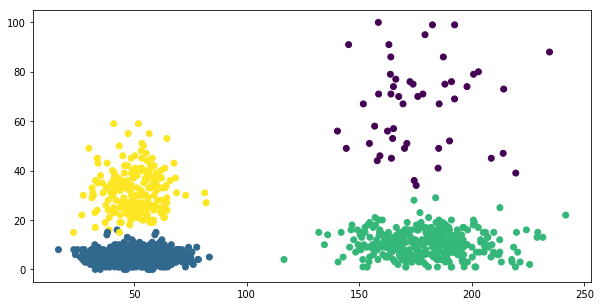

In [2]:
# Si se quiere asegurar la reproducibilidad de la práctica se fija la semilla aleatoria
# Sin embargo, si lo que se busca es simular una situación real puede ser más interesante evaluar múltiples casuísticas con
# inicializaciones distintas.
np.random.seed(17)

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_densidad.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
Dx = D[:,0:2]
Dy = D[:,2]

print('El dataset cargado tiene',Dx.size,'instancias.')

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

*El primer paso que se realizará es la detección del número óptimo de clusters. Para ello se utilizarán dos medidas de evaluación intrínseca (ancho de silueta y RMSSTD) y el procedimiento del codo.*<br>

*La elección del RMSSTD se ha hecho debido a que, a pesar de no ser los casos más extremos, las otras medidas que se utilizaran durante el trabajo, ancho de silueta y Calinski-Harabaz, son subóptimas para evaluar clusters con bajas densidades. En cambio, RMSSTD nos ofrece una visión de las distancias intraclústers, que, conociendo que siemrpe decrecerá con K, se podrá utilizar para la regla del codo.*

Text(0, 0.5, 'Raíz del cuadrado de la media de la Desviación Típica')

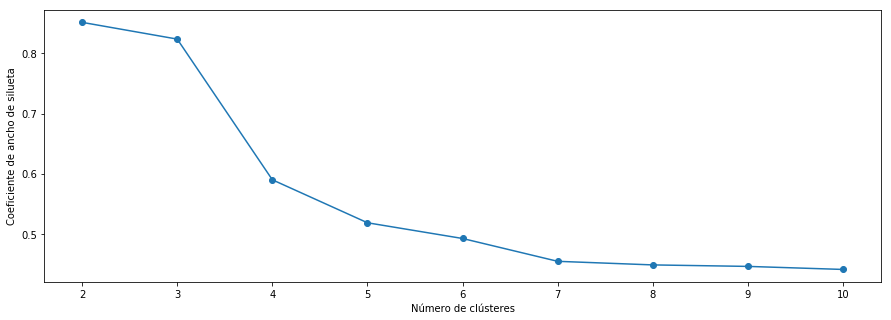

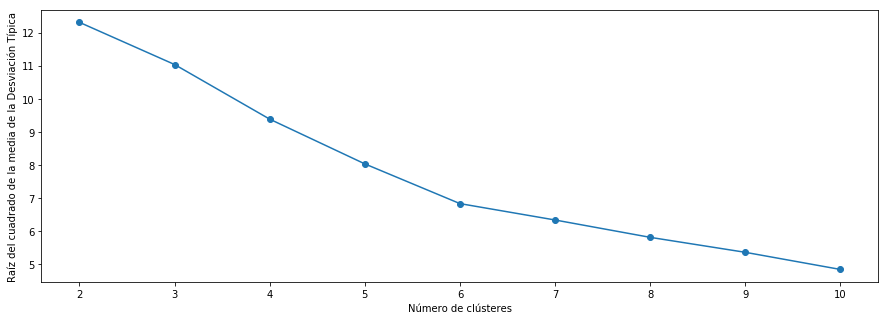

In [3]:
# Se importan medidas implementadas en sklearn
from sklearn.metrics import silhouette_score, calinski_harabaz_score

rsilueta = np.zeros(9)
rRMSSTD = np.zeros(9)

for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k, init='k-means++')
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rRMSSTD[k-2] = medida_RMSSTD(Dx, Dyp_sk, cDx_sk)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11), rsilueta, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Coeficiente de ancho de silueta")

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11), rRMSSTD, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Raíz del cuadrado de la media de la Desviación Típica")

*Si se observan las medidas de ancho de silueta para las distintas cantidades de clusters se puede ver un cambio de pendiente asociable a la regla del codo en k=3, mientras que la RMSSTD no nos aporta demasiada información. Al tener la información a priori de que hay 4 clusters, se seguirá el análisis con k=3 y k=4.*

In [4]:
# Se inicializa KMeans con el número de clústeres a buscar
modelo3 = KMeans(n_clusters=3, init='k-means++')
# Se aprende el 
modelo3 = modelo3.fit(Dx)
# Se predicen los clusters
Dyp_sk3 = modelo3.predict(Dx)
# Se obtienen los centros de los clústeres
cDx_sk3 = modelo3.cluster_centers_

In [5]:
# Se inicializa KMeans con el número de clústeres a buscar
modelo4 = KMeans(n_clusters=4, init='k-means++')
# Se aprende el 
modelo4 = modelo4.fit(Dx)
# Se predicen los clusters
Dyp_sk4 = modelo4.predict(Dx)
# Se obtienen los centros de los clústeres
cDx_sk4 = modelo4.cluster_centers_

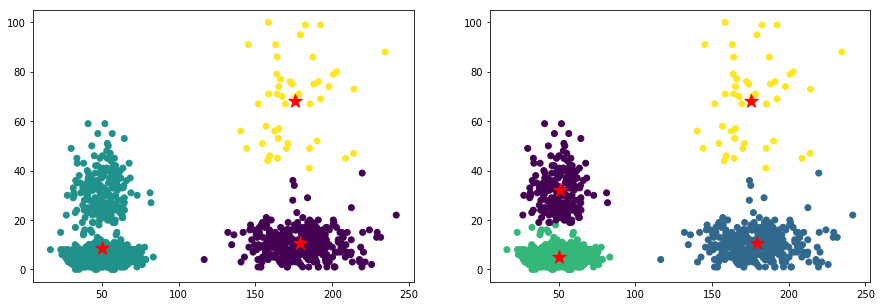

In [6]:
# Se muestra el resultado de las asignaciones finales
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].scatter(Dx[:,0],Dx[:,1], c=Dyp_sk3)
ax[0].scatter(cDx_sk3[:,0],cDx_sk3[:,1], marker='*', s=200, c='r')

ax[1].scatter(Dx[:,0],Dx[:,1], c=Dyp_sk4)
ax[1].scatter(cDx_sk4[:,0],cDx_sk4[:,1], marker='*', s=200, c='r')

*Finalmente se aplican las distintas medidas extrínsecas para evaluar el comportamiento del algoritmo.*

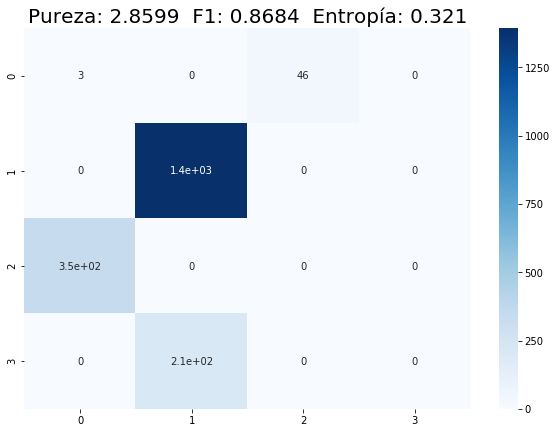

In [7]:
# Debido a que los valores de los clusteres reales van de 1 a 4 y que los calculados van de 0 a 3,
# se aplica un factor de corrección para calcular la matriz de confusión.
extrinsic_evaluation(Dy-[1], Dyp_sk3)

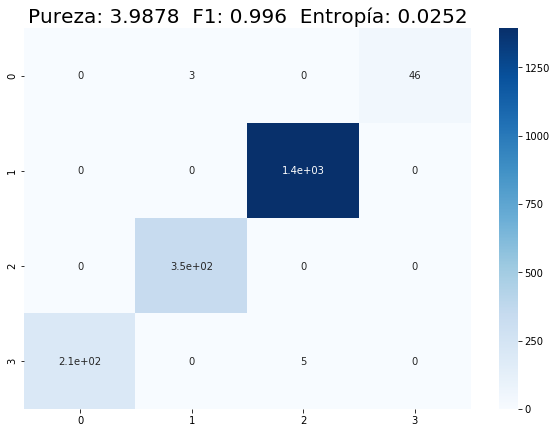

In [8]:
# Debido a que los valores de los clusteres reales van de 1 a 4 y que los calculados van de 0 a 3,
# se aplica un factor de corrección para calcular la matriz de confusión.
extrinsic_evaluation(Dy-[1], Dyp_sk4)

### Resultados

Se puede observar que los resultados del algoritmo con k=4 son muy buenos debido a que los datos se adaptan perfectamente a un agrupamiento por particiones. Sin embargo, sin conocimiento previo de los datos, se hubiera escogido k=3, con un resultado algo peor.

# Clustering Jerárquico Aglomerativo

Como ejemplo de agrupamiento jerárquico se utilizará la aproximación aglomerativa debido a que hasta el momento la divisiva raramente se utiliza en aplicaciones reales.

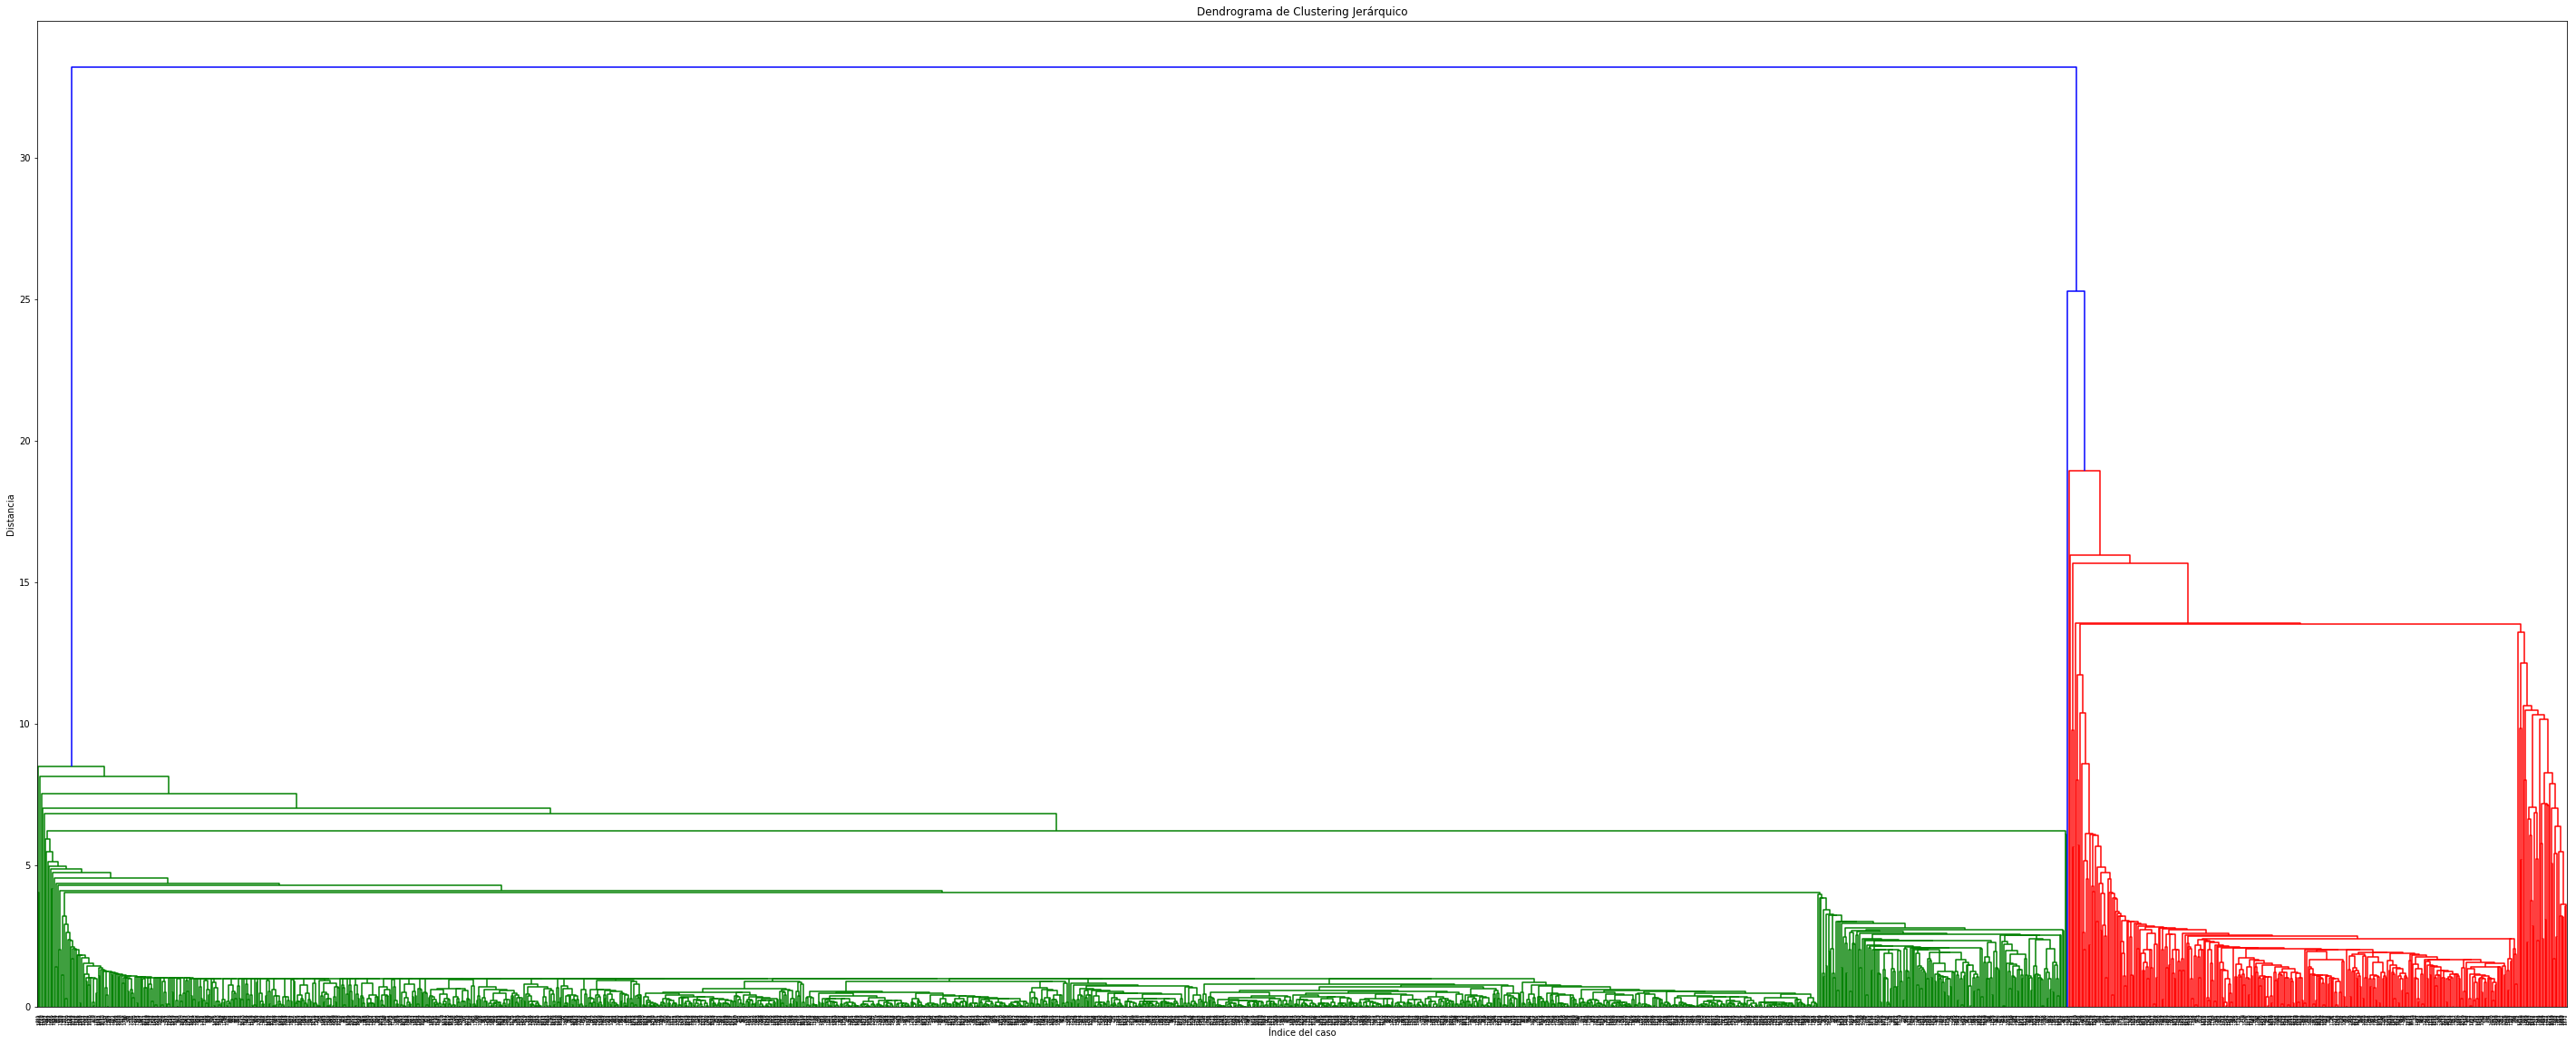

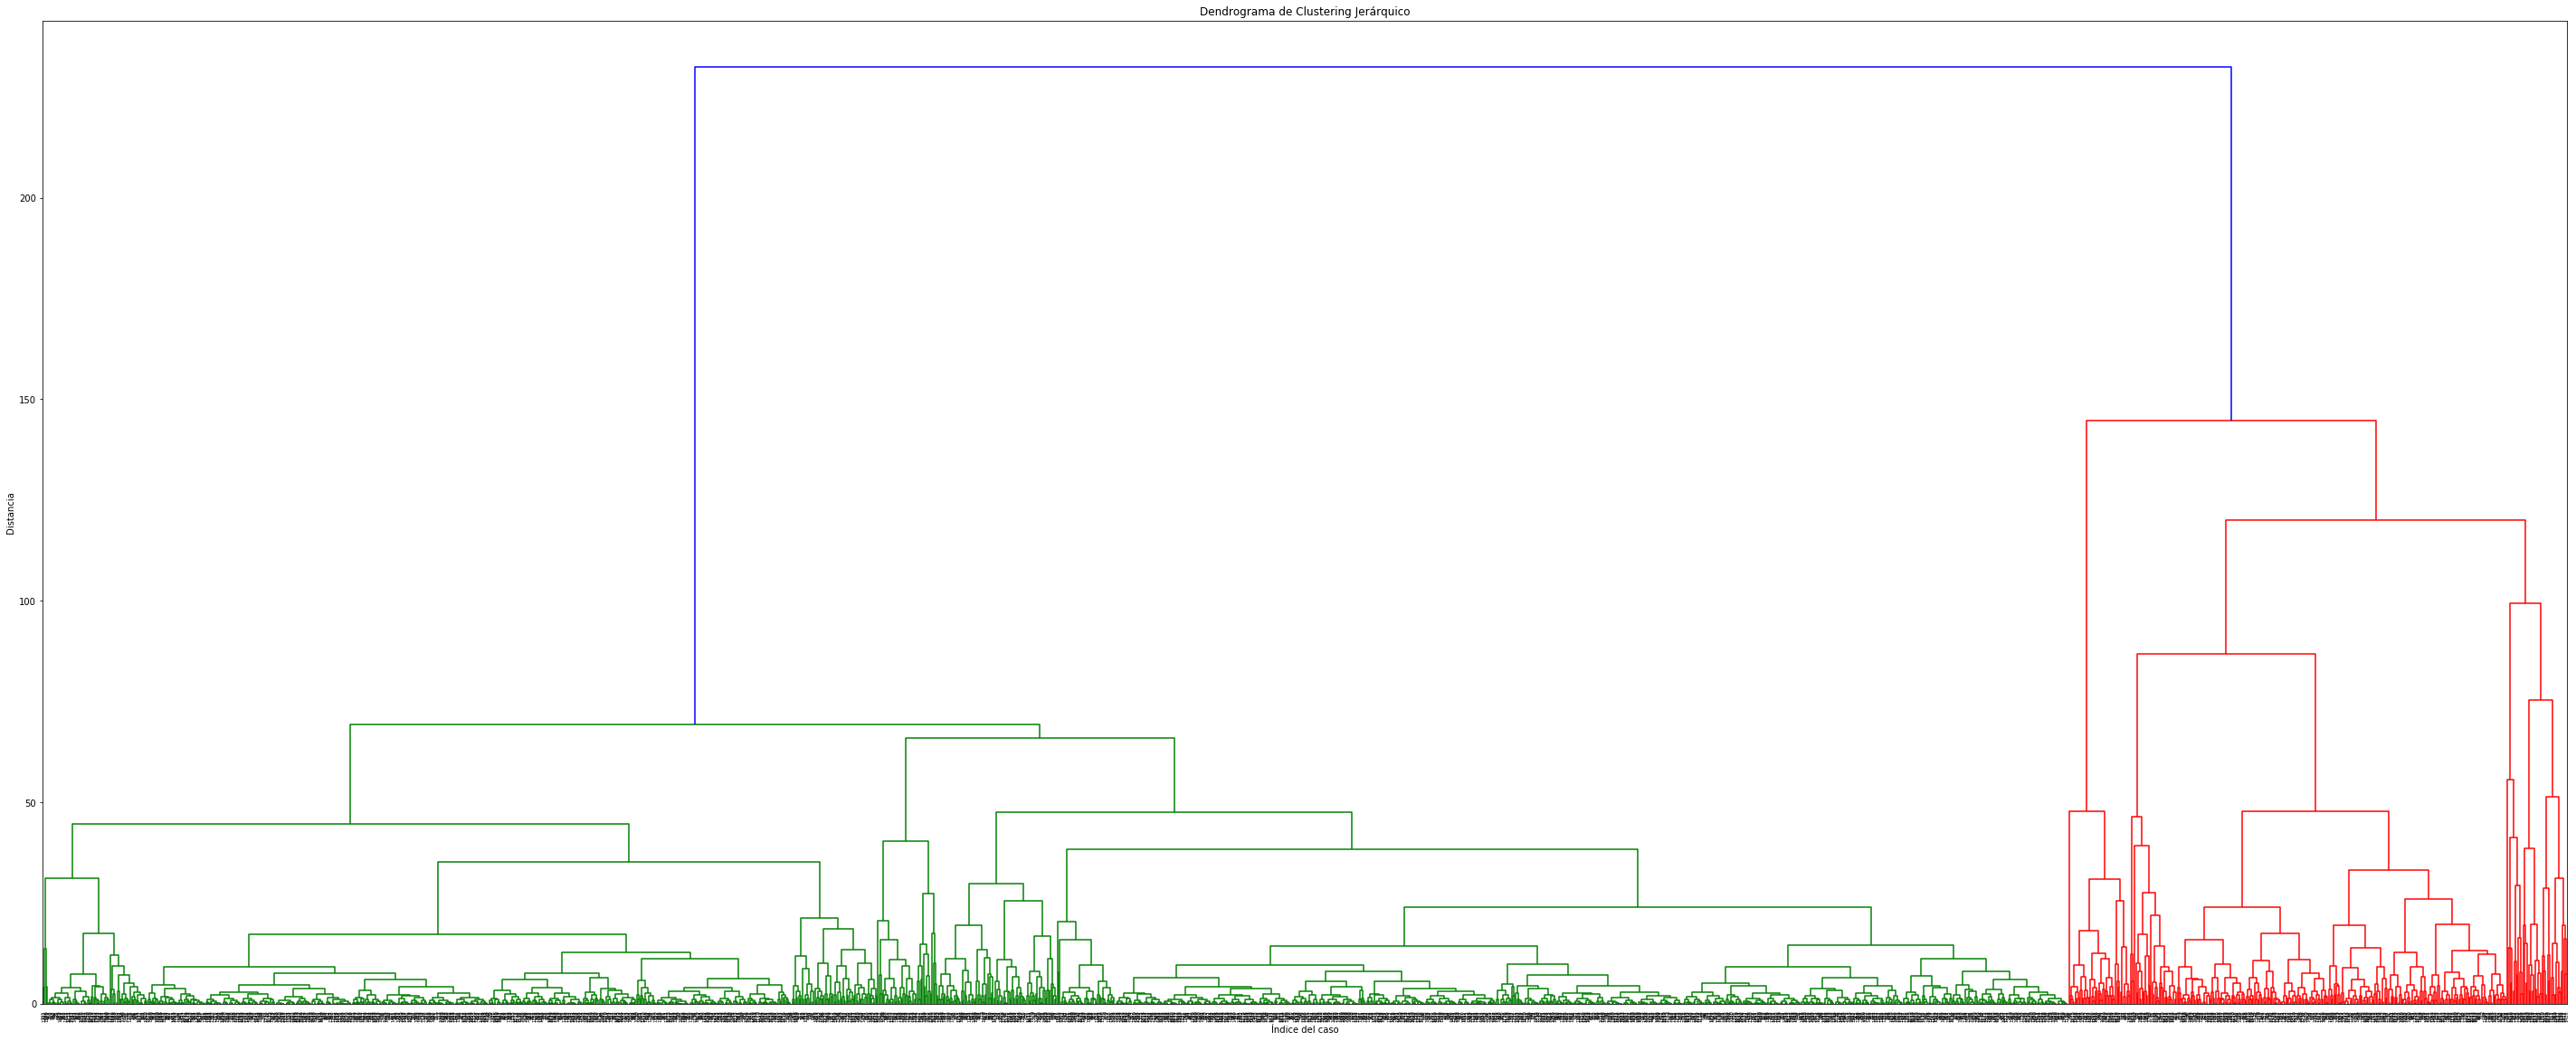

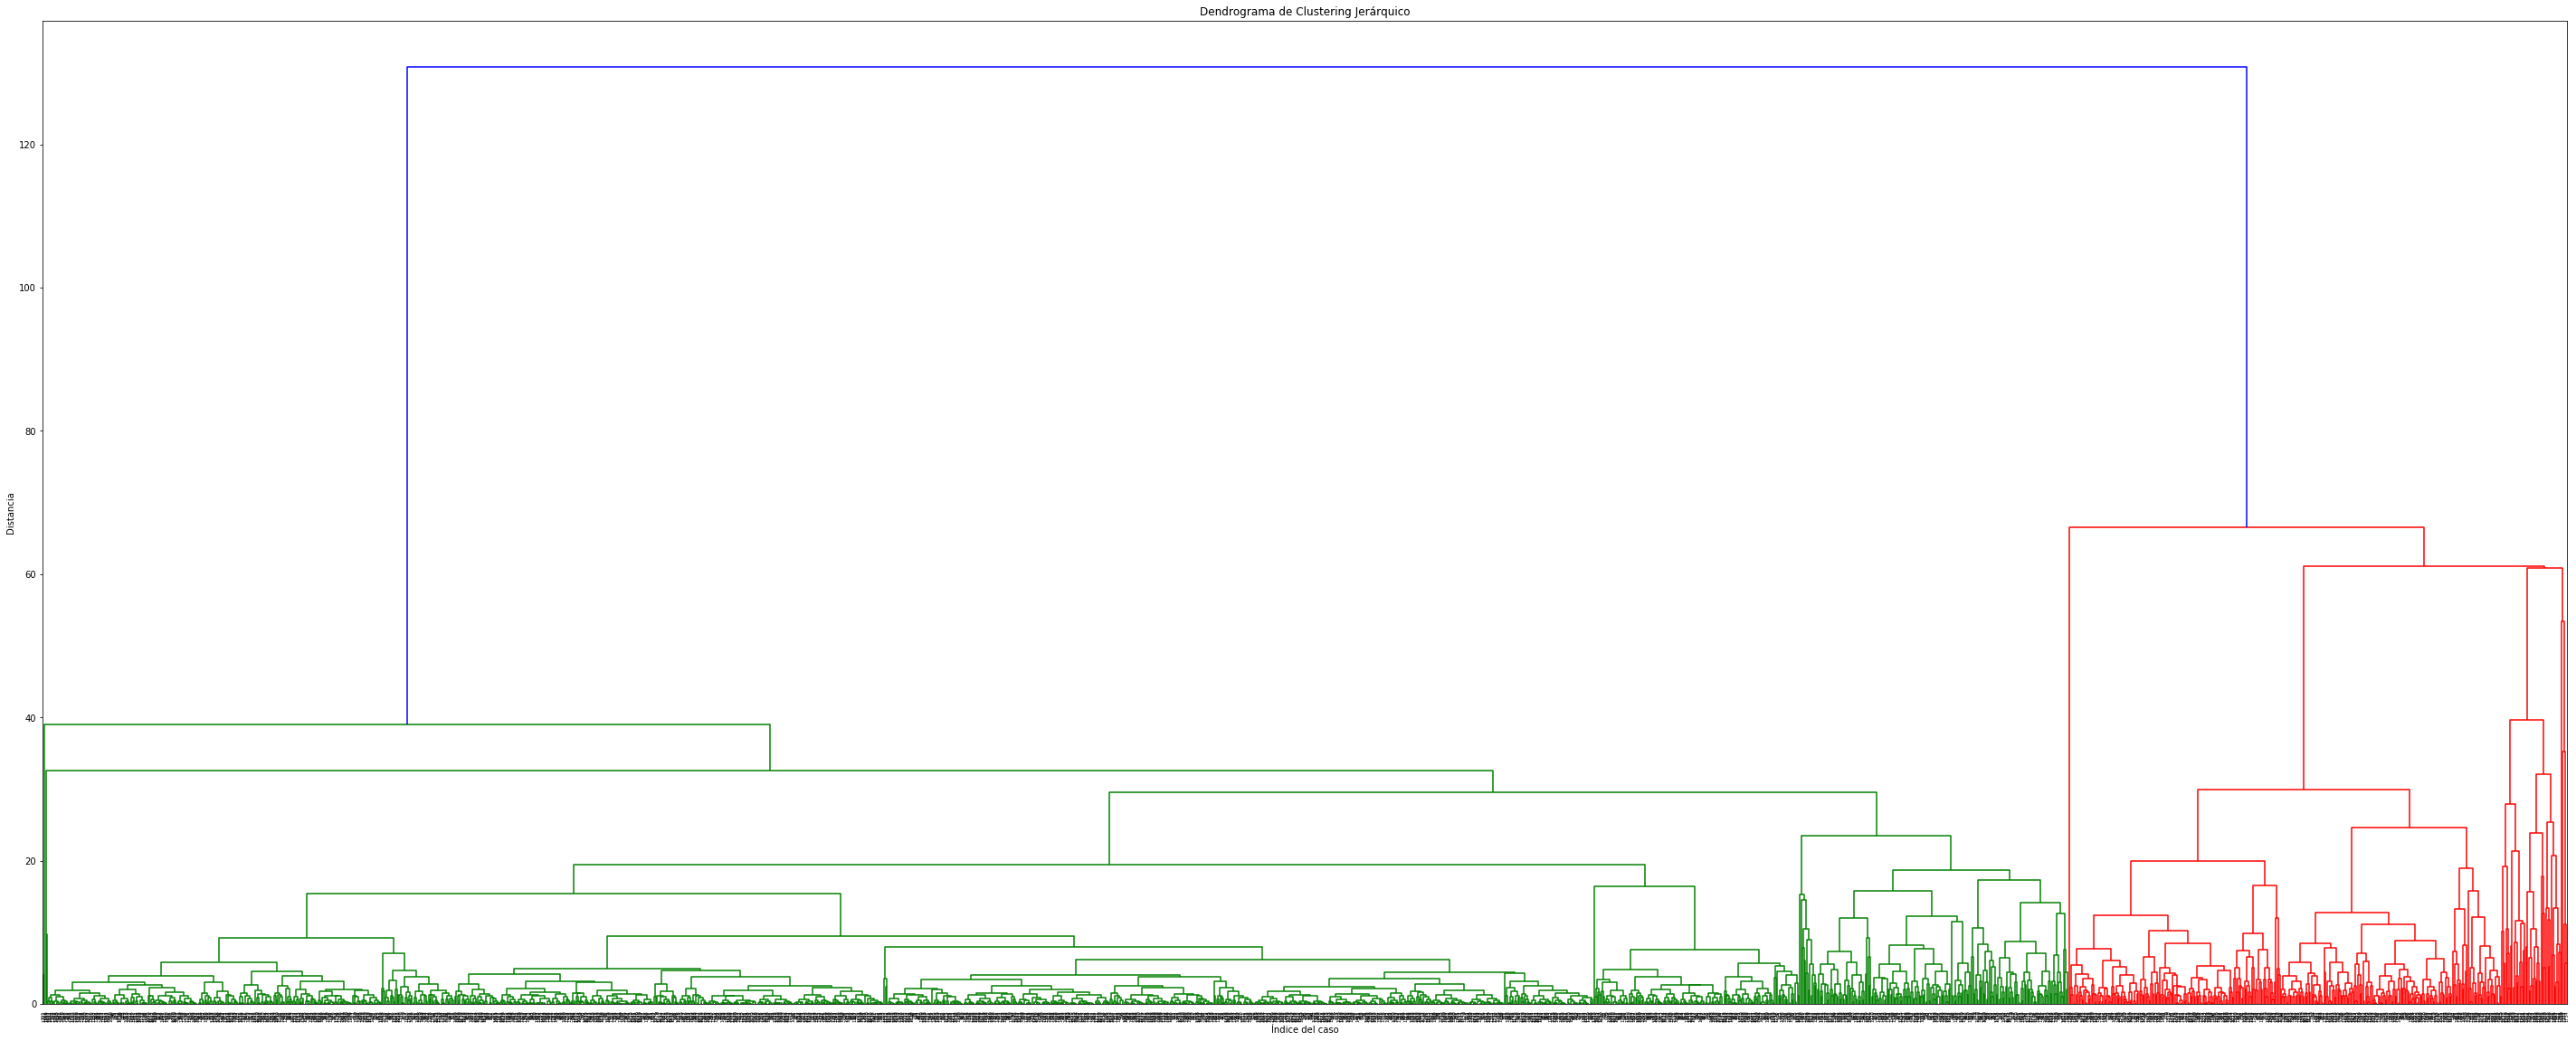

In [9]:
from scipy.cluster.hierarchy import linkage, fcluster, cut_tree, dendrogram

# Se generan 3 modelos utilizando los distintos tipos de cálculo de disimilitud intercluster estudiados en clase
modelo_single = linkage(Dx, 'single')   # disimilitud mínima
modelo_completo = linkage(Dx, 'complete') # disimilitud máxima
modelo_average = linkage(Dx, 'average')  # disimilitud media

plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_single)
plt.show()

plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_completo)
plt.show()

plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_average)
plt.show()

*En este caso se compararán las tres disimilitudes estudiadas en clase y por ello fijaremos el número de clusters en 4, como se ha podido ver en el anterior apartado.*<br>

*Para empezar se muestran visualmente los resultados.*

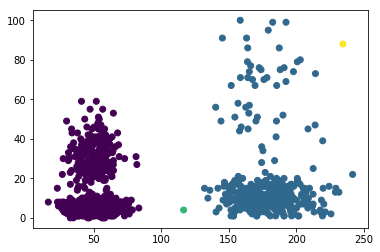

In [10]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo_single, n_clusters=4).flatten())
plt.show()

*No funciona muy bien. Los puntos amarillo y verde los considera un clúster y no logra separar.*

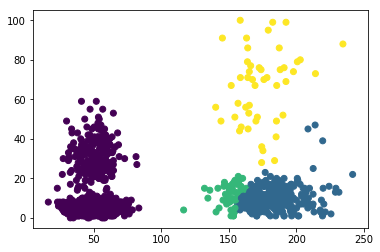

In [11]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo_completo, n_clusters=4).flatten())
plt.show()

*No funciona muy bien. Divide el cluster inferior de la derecha antes que los de la izquierda*

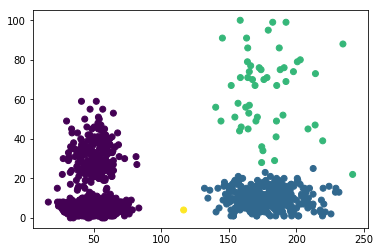

In [12]:
plt.scatter(Dx[:,0], Dx[:,1], c=cut_tree(modelo_average, n_clusters=4).flatten())
plt.show()

*No funciona muy bien. El punto amarillo lo considera un clúster y no logra separar el de la izquierda.*

*En los dos últimos ejemplos parecería que si se aumentara el número de clusters el resultado podría ser mejor. Se ha probado y no es así, el algoritmo tiende a dividir los clusters de la derecha en más partes antes que los dos de la izquierda.*

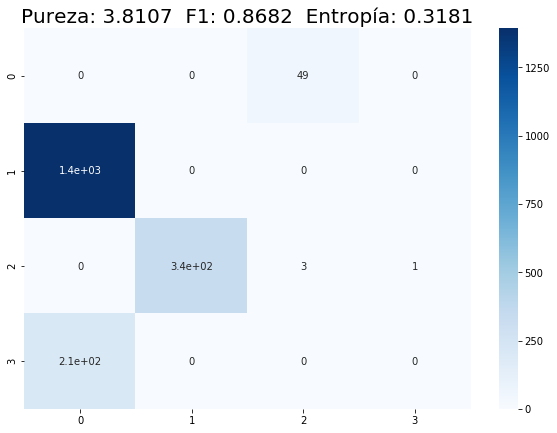

In [13]:
# Se utiliza el modelo que ha devuelto mejores resultados (modelo_average) para la evaluación de métricas. 
extrinsic_evaluation(Dy-[1], cut_tree(modelo_average, n_clusters=4).flatten())

### Resultados

En este caso los valores de las medidas extrínsecas y la evaluación visual son significativamente peores que para Kmeans++.<br>

La poca densidad del cluster de arriba a la derecha contra la gran proximidad de los de la izquierda hacen que los algoritmos jerárquicos no sean una buena opción.

# Agrupamiento Espectral

Como caso paradigmático de agrupamiento espectral se utilizará un grafo con K vecinos más cercanos y una laplaciana normalizada (utilizada en la función SpectralClustering de sklearn).<br>

Para empezar, buscamos el número óptimo de vecinos para el KNN.

Text(0, 0.5, 'Medida de ancho de silueta')

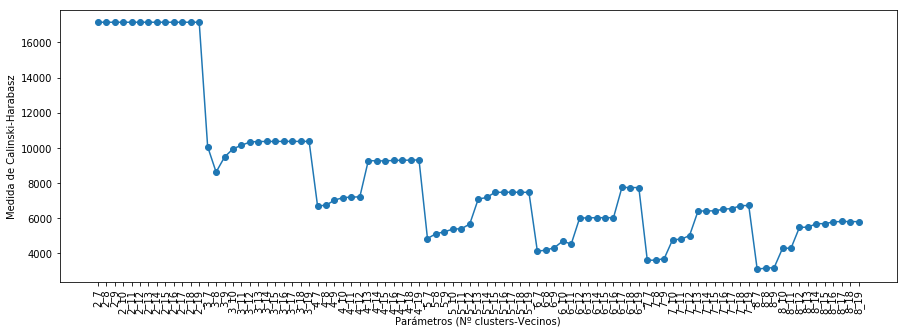

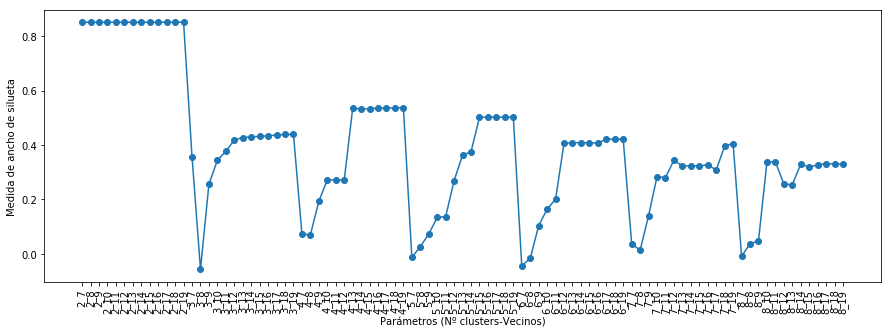

In [14]:
from sklearn.cluster import SpectralClustering

rSpectral_cal = {}
rSpectral_sil = {}
for K in np.arange(2,9):
    for knn in np.arange(7,20,1):
        modelo = SpectralClustering(n_clusters = K, 
                                    affinity = 'nearest_neighbors', n_neighbors = knn,
                                    random_state = 0)
        Dyp_sk = modelo.fit_predict(Dx)
        rSpectral_cal[str(K) + '_' + str(knn)] = calinski_harabaz_score(Dx, Dyp_sk)
        rSpectral_sil[str(K) + '_' + str(knn)] = silhouette_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rSpectral_cal.keys(), rSpectral_cal.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Nº clusters-Vecinos)")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rSpectral_sil.keys(), rSpectral_sil.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Nº clusters-Vecinos)")
ax.set_ylabel("Medida de ancho de silueta")

*Se observa que para pocos vecinos el algoritmo no es capaz de crear un grafo totalmente conectado.*<br>

*También se ve que de 18 vecinos en adelante, en ningún caso el algoritmo mejora.*<br>

*Se probarán dos configuraciones, 2 clusters y 12 vecinos (el resultado sería el mismo pero con menos vecinos el grafo no queda conectado) y 4 clusters y 15 vecinos.*

Text(0.5, 1.0, '4 Clusters con 15 vecinos')

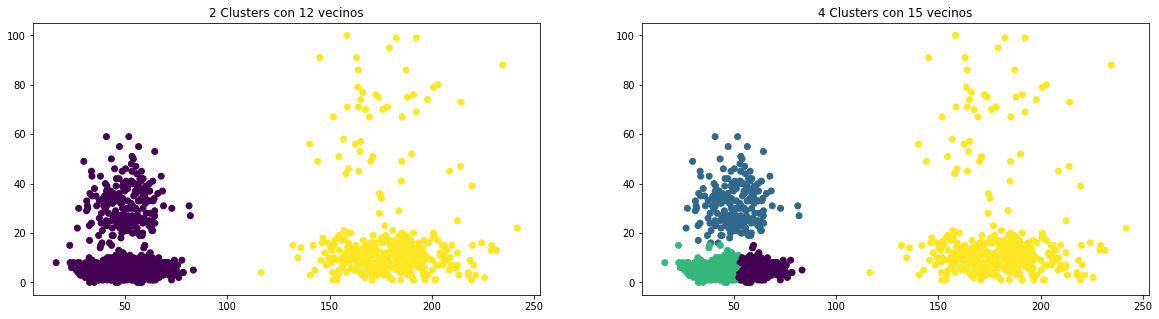

In [15]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

clustering_2_12 = SpectralClustering(n_clusters = 2, 
                                affinity = 'nearest_neighbors', n_neighbors = 12,
                                random_state = 0).fit(Dx)
ax[0].scatter(Dx[:,0], Dx[:,1], c=clustering_2_12.labels_)
ax[0].set_title('2 Clusters con 12 vecinos')
    
clustering_4_15 = SpectralClustering(n_clusters = 4, 
                                affinity = 'nearest_neighbors', n_neighbors = 15,
                                random_state = 0).fit(Dx)
ax[1].scatter(Dx[:,0], Dx[:,1], c=clustering_4_15.labels_)
ax[1].set_title('4 Clusters con 15 vecinos')
    

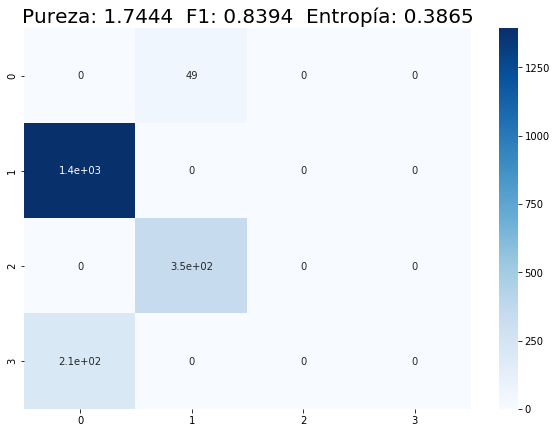

In [16]:
# Se utiliza el modelo con K=2 y knn=12 visto arriba
extrinsic_evaluation(Dy-[1], clustering_2_12.fit_predict(Dx).flatten())

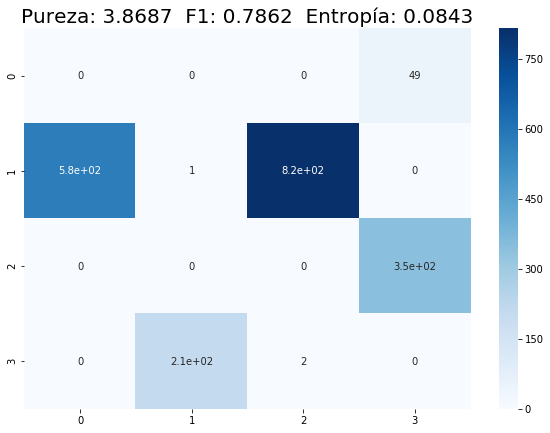

In [17]:
# Se utiliza el modelo con K=4 y knn=15 visto arriba
extrinsic_evaluation(Dy-[1], clustering_4_15.fit_predict(Dx).flatten())

### Resultados

Como era lógico esperar, el caso de K=4 y knn=15 obtiene mejores resultados en Pureza y Entropía debido a que los valores "reales" estan agrupados en 4 clusters. Curiosamente, la medida F1 tiene una valor mejor para K=2 cosa que es debida a que la F1 "acepta" muy bién que 2 clusters reales queden englobados en un solo cluster predicho (como está pasando).

# Agrupamiento basado en densidad - DBSCAN

En el caso del agrupamiento basado en densidad, al haber visto tres métodos con propiedades significativamente distintas se ha decidido aplicar los 3 y realizar ajuste de parámetros hasta llegar a la mejor solución posible

*En una primera instancia se utilizaron las medidas de Calinski-Harabaz y de Ancho de Silueta, pero la segunda en este agrupamiento prácticamente nunca nos daba información relevante por lo que se ha sustituido por el índice de Davies-Bouldin.*<br>

https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index

Text(0, 0.5, 'Índice de Davies-Bouldin')

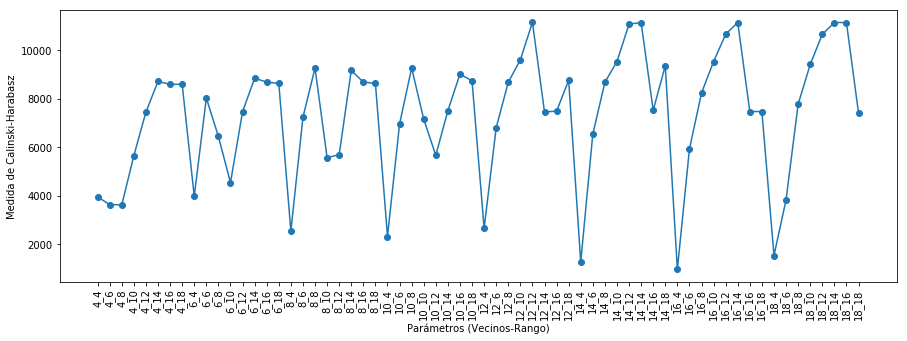

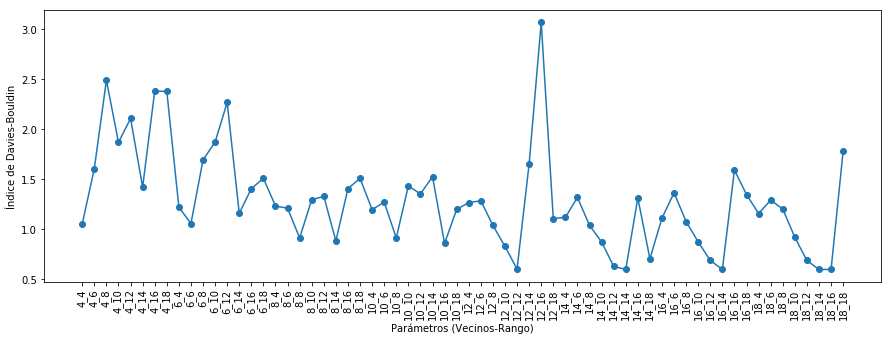

In [18]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import davies_bouldin_score

rDBSCAN_cal = {}
rDBSCAN_dav = {}

# El warning que ignoramos es un comportamiento esperado en según que casos para la davies_bouldin:
# https://github.com/scikit-learn/scikit-learn/issues/12611
with np.errstate(divide='ignore'):
    for M in np.arange(4,20,2):
        for eps in np.arange(4,20,2):
            modelo = DBSCAN(eps=eps, min_samples=M)
            Dyp_sk = modelo.fit_predict(Dx)
            rDBSCAN_cal[str(M) + '_' + str(eps)] = calinski_harabaz_score(Dx, Dyp_sk)
            rDBSCAN_dav[str(M) + '_' + str(eps)] = davies_bouldin_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rDBSCAN_cal.keys(), rDBSCAN_cal.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Vecinos-Rango)")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rDBSCAN_dav.keys(), rDBSCAN_dav.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Vecinos-Rango)")
ax.set_ylabel("Índice de Davies-Bouldin")

*De los resultados anteriores deducimos que la mejor combinación de parámetros es un ancho de vecindario de 12 y un número de vecinos en él para considerar un punto como nuclear, también de 12*

Text(0.5, 1.0, 'Algoritmo DBSCAN')

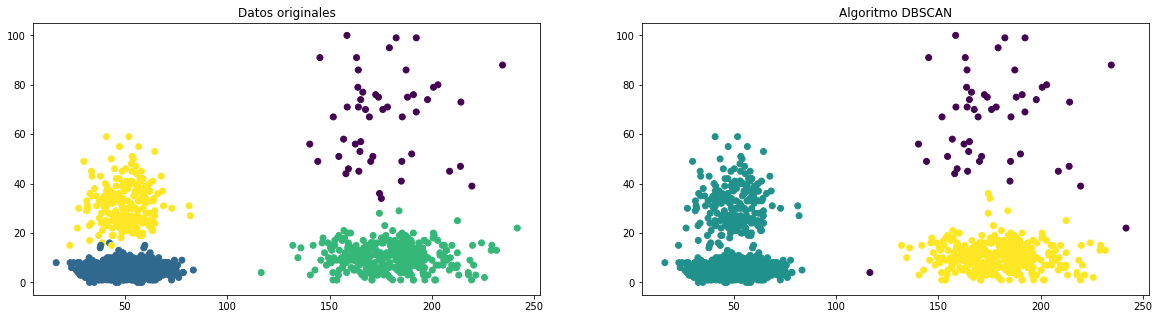

In [19]:
eps = 12
M = 12
clustering = DBSCAN(eps=eps, min_samples=M).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c= Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)
ax[0].set_title('Datos originales')
ax[1].set_title('Algoritmo DBSCAN')

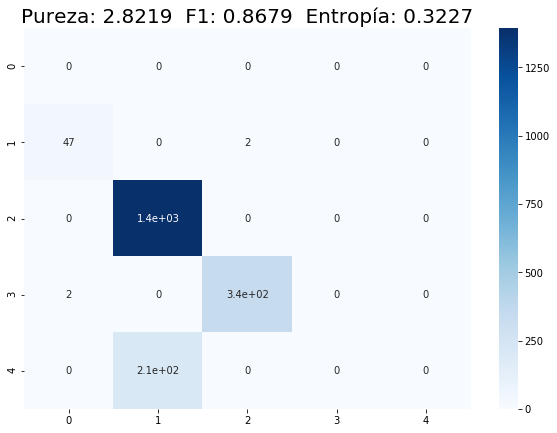

In [20]:
# Debido a que los valores de los clusteres reales van de 1 a 4 y que los calculados van de 0 a 3,
# se aplica un factor de corrección para calcular la matriz de confusión.
extrinsic_evaluation(Dy-[1], DBSCAN(eps=12, min_samples=12).fit_predict(Dx).flatten())

### Resultados

Se observa que ni en el mejor caso se llega a un clustering medianamente aceptable. El algoritmo solo consigue detectar 2 clústers y una gran cantidad de puntos de ruido. Esto es debido a que DBSCAN no es ni mucho menos el más adecuado para clasificar clusters con densidades distintas.<br>

*En la matriz de confusión aparece una dimensión más debido a que DBSCAN el ruido lo asigna a -1 y no a un cluster que se pueda comparar.*

# Agrupamiento basado en densidad - Mean Shift

Text(0, 0.5, 'Índice de Davies-Bouldin')

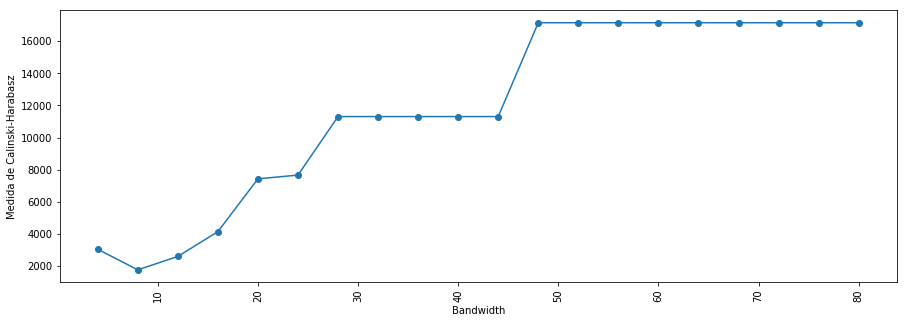

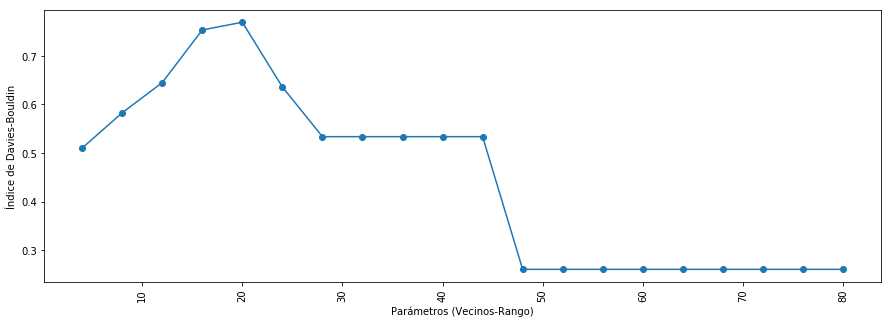

In [21]:
from sklearn.cluster import MeanShift

rMeanShift_cal = {}
rMeanShift_dav = {}

# El warning que ignoramos es un comportamiento esperado en según que casos para la davies_bouldin:
# https://github.com/scikit-learn/scikit-learn/issues/12611
with np.errstate(divide='ignore'):
    for bwd in np.arange(4,81,4):
        modelo = MeanShift(bandwidth = bwd, n_jobs=4)
        Dyp_sk = modelo.fit_predict(Dx)
        rMeanShift_cal[bwd] = calinski_harabaz_score(Dx, Dyp_sk)
        rMeanShift_dav[bwd] = davies_bouldin_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rMeanShift_cal.keys(), rMeanShift_cal.values(), linestyle='-', marker='o')
ax.set_xlabel("Bandwidth")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rMeanShift_dav.keys(), rMeanShift_dav.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Vecinos-Rango)")
ax.set_ylabel("Índice de Davies-Bouldin")

*A pesar de ver mejores métricas a partir de un ancho de banda de 50, conociendo el algoritmo y las métricas se puede entrever que en ese punto se ha pasado a 2 clusters. Por ello se escogerá bwd=30 que puede llevar a un resultado más acertado.*

Text(0.5, 1.0, 'Algoritmo Mean-Shift')

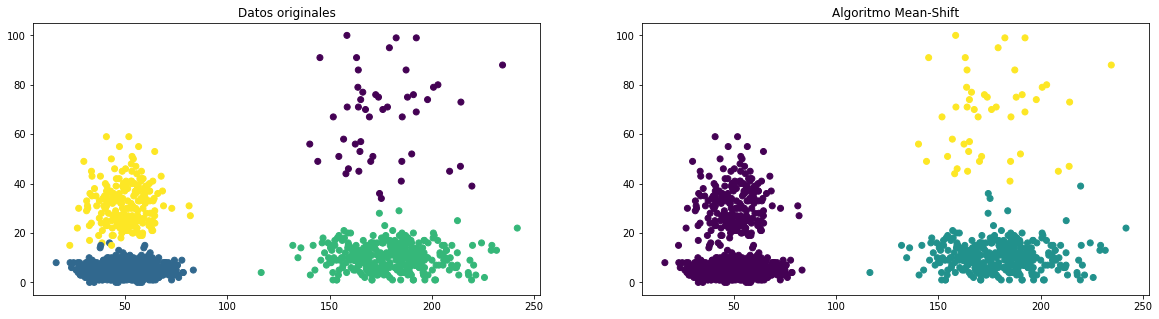

In [22]:
clustering = MeanShift(bandwidth = 30).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)
ax[0].set_title('Datos originales')
ax[1].set_title('Algoritmo Mean-Shift')

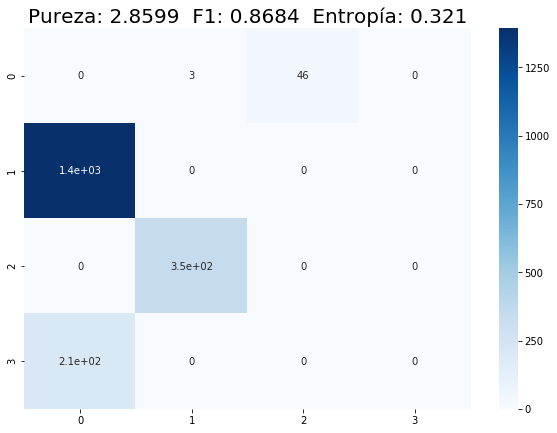

In [23]:
# Debido a que los valores de los clusteres reales van de 1 a 4 y que los calculados van de 0 a 3,
# se aplica un factor de corrección para calcular la matriz de confusión.
extrinsic_evaluation(Dy-[1], MeanShift(bandwidth = 30).fit_predict(Dx).flatten())

### Resultados

Los resultados obtenidos son ligeramente mejores a los de DBSCAN. Principalmente se está agrupando en un cluster lo que anteriormente era ruido. Por otro lado, la gran densidad y cercanía de los dos clusters de la izquierda los hacen indivisibles para estos algoritmos.

# Agrupamiento basado en densidad - Affinity Propagation

In [ ]:
# Función que se utilizará para pintar las relaciones entre los representates finales y sus representados en cada cluster
def dibujar_clusteringAP(modelo):
    fig = plt.figure(figsize=(10, 5))

    ncentros = modelo.cluster_centers_indices_.size
    colores = 'bgrcmyk'

    for k in np.arange(ncentros):
        kc = k % len(colores)

        centro = Dx[modelo.cluster_centers_indices_[k],:]
        miembros_cluster = np.where(modelo.labels_ == k)[0]

        plt.scatter(Dx[miembros_cluster, 0], Dx[miembros_cluster, 1], c=colores[kc], s=3)
        for i in miembros_cluster:
            plt.plot([centro[0], Dx[i,0]], [centro[1], Dx[i,1]], c = colores[kc])

    plt.scatter(Dx[modelo.cluster_centers_indices_,0], Dx[modelo.cluster_centers_indices_,1], 
                s=50, c = 'black')

    plt.title('Núm. clústeres: %s' % ncentros)
    plt.show()

Text(0, 0.5, 'Índice de Davies-Bouldin')

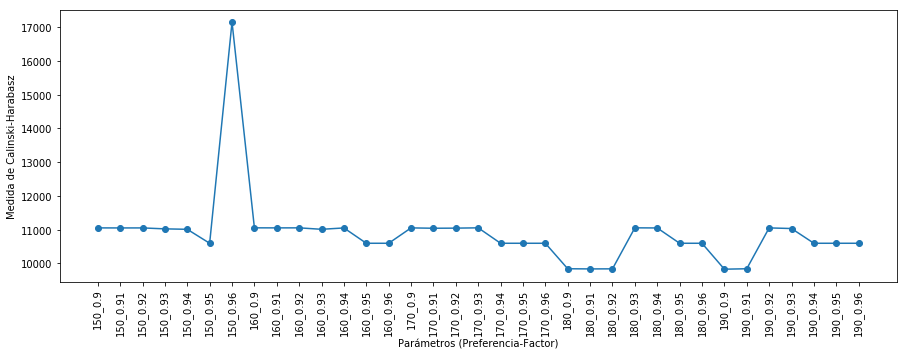

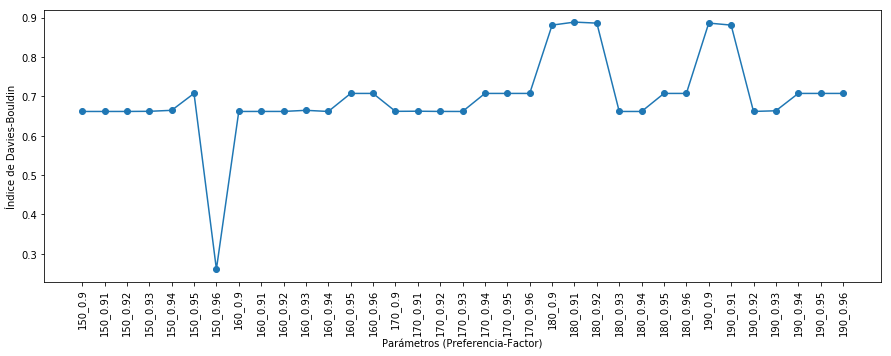

In [ ]:
# He tenido que pasar un buen rato modificando el factor de aprendizaje y las preferencias hasta obtener 4 clusters
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AffinityPropagation

mSimilitud = euclidean_distances(Dx)
mSimilitud = -mSimilitud**2

rAffinity_cal = {}
rAffinity_dav = {}

# El warning que ignoramos es un comportamiento esperado en según que casos para la davies_bouldin:
# https://github.com/scikit-learn/scikit-learn/issues/12611
with np.errstate(divide='ignore'):
    for pref in np.arange(150,191,10):
        for factor in np.arange(0.9,0.961,0.01):
            preferencia = np.median(mSimilitud) * pref
            np.fill_diagonal(mSimilitud, preferencia)
            modelo = AffinityPropagation(preference=preferencia, damping=factor)
            Dyp_sk = modelo.fit_predict(Dx)
            # Condición para parar la iteración
            if np.max(Dyp_sk) == -1 or len(set(Dyp_sk)) > 100:
                print("Error: pref: %d, factor: %f ",(pref,factor))
                break
            rAffinity_cal[str(pref) + '_' + str(round(factor,2))] = calinski_harabaz_score(Dx, Dyp_sk)
            rAffinity_dav[str(pref) + '_' + str(round(factor,2))] = davies_bouldin_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rAffinity_cal.keys(), rAffinity_cal.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Preferencia-Factor)")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(rAffinity_dav.keys(), rAffinity_dav.values(), linestyle='-', marker='o')
ax.set_xlabel("Parámetros (Preferencia-Factor)")
ax.set_ylabel("Índice de Davies-Bouldin")

*Vistos los resultados obtenidos (después de unas cuantas iteraciones y pruebas visuales) se decide utilizar un valor multiplicativo de las preferencias de 190 y el damping de 0.94*

Text(0.5, 1.0, 'Algoritmo Affinity Propagation')

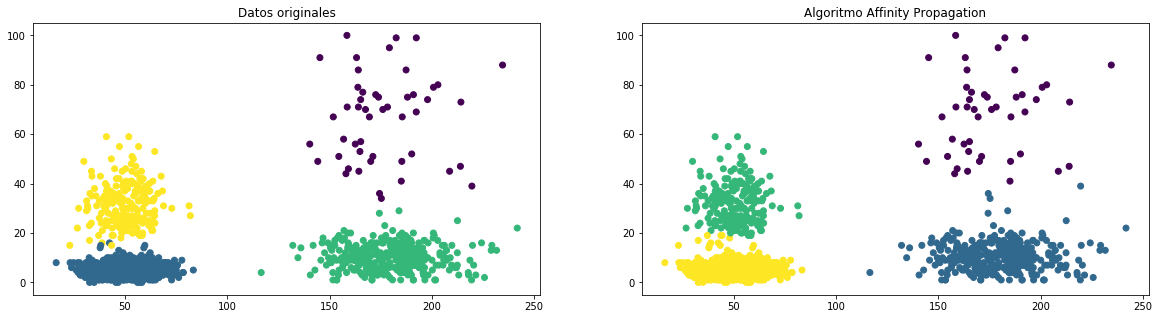

In [ ]:
clustering = AffinityPropagation(preference=np.median(mSimilitud) * 190, damping=0.94).fit(Dx)

# Mostrar resultados
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0], Dx[:,1], c = clustering.labels_)
ax[0].set_title('Datos originales')
ax[1].set_title('Algoritmo Affinity Propagation')

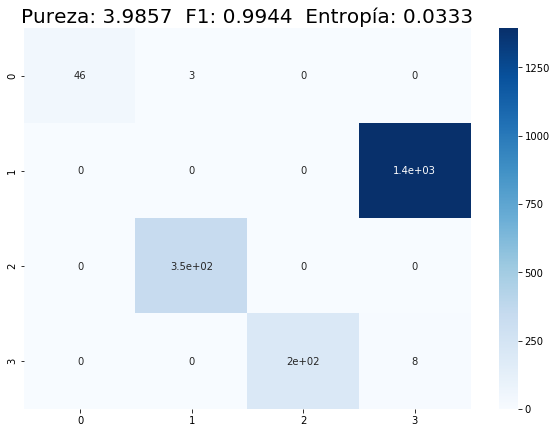

In [ ]:
# Debido a que los valores de los clusteres reales van de 1 a 4 y que los calculados van de 0 a 3,
# se aplica un factor de corrección para calcular la matriz de confusión.
extrinsic_evaluation(Dy-[1], AffinityPropagation(preference=np.median(mSimilitud) * 190, damping=0.94).fit_predict(Dx).flatten())

### Resultados

Sin lugar a dudas, con Affinity propagation, se ha conseguido un muy buen agrupamiento con valores de todas las medidas extrínsecas muy alto. El problema sigue siendo que se sigue sin conseguir una buena manera de "simular" un ajuste de parámetros eficaz.

# Mixtura de Gaussianas y algoritmo EM

Finalmente se provará el algoritmo EM como representante de un algoritmo probabilístico.<br>

En este caso, el parámetro más importante a ajustar vuelve a ser el número de agrupamientos. Se podría hacer un ajuste de parámetros al estilo del que se ha hecho para Kmeans++, pero los resultados serían parecidos considerando que EM al final se podría considerar una evolución más generalizada de Kmeans. Por ello, se aplicará directamente k=4.

In [ ]:
from sklearn.mixture import GaussianMixture

# Se inicializa el método con el número de clústeres (componentes) a buscar
modelo = GaussianMixture(n_components = 4, max_iter = 200)
# Se aprende el modelo
modelo = modelo.fit(Dx)
# Se predicen las asignaciones a clústeres
Dyp_sk = modelo.predict(Dx)

Text(0.5, 1.0, 'Algoritmo EM')

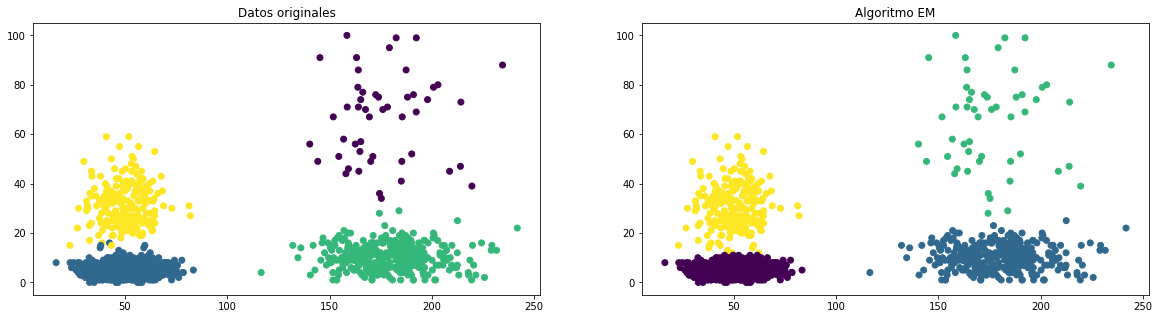

In [ ]:
# Mostrar resultados. Parece funcionar bien, pero hay algunos puntos que no se asignan correctamente
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(Dx[:,0], Dx[:,1], c = Dy)
ax[1].scatter(Dx[:,0],Dx[:,1], c=Dyp_sk)
ax[0].set_title('Datos originales')
ax[1].set_title('Algoritmo EM')

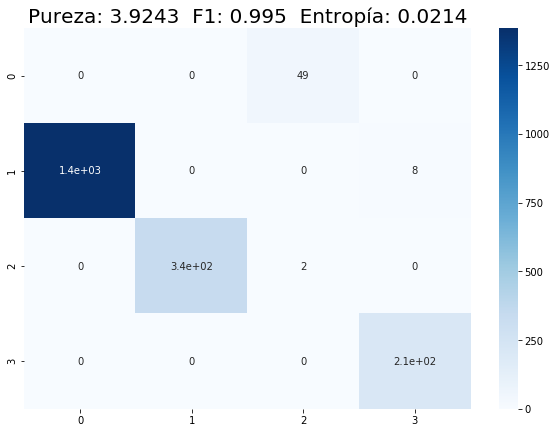

In [ ]:
extrinsic_evaluation(Dy-[1], Dyp_sk)

### Resultados

Como ya se había predicho, se esperaba un resultado similar al de Kmeans++ para 4 clusters y así ha sido.<br>

# AGRUPAMIENTO NO CONOCIDO

In [ ]:
import io
import requests
from pprint import pprint

# DATASET DE AUTOS_MPG DE UCI
url_autos = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
data_names = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model year','origin','car name']

response=requests.get(url_autos).content
ds_autos=pd.read_csv(io.StringIO(response.decode('utf-8')),delim_whitespace=True,header=None, names = data_names,na_values='?')

# Limpieza de las instancias con valores nulos
ds_autos = ds_autos.dropna()

# EJEMPLO DE DATOS
ds_autos.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
321,32.2,4,108.0,75.0,2265.0,15.2,80,3,toyota corolla
311,32.1,4,98.0,70.0,2120.0,15.5,80,1,chevrolet chevette
276,21.6,4,121.0,115.0,2795.0,15.7,78,2,saab 99gle
215,13.0,8,318.0,150.0,3755.0,14.0,76,1,dodge d100
250,19.4,8,318.0,140.0,3735.0,13.2,78,1,dodge diplomat


In [ ]:
# ESTADÍSTICA DEL DATASET
ds_autos.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [ ]:
# Correlación entre las columnas
ds_autos.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329,0.580541,0.565209
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
model year,0.580541,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,0.565209,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Transformación a array de numpy eliminando el modelo del coche, origen y año
D = np.array(ds_autos)[:,:-3]

# Normalizamos los valores
scaler = MinMaxScaler()
scaler.fit(D)
# Dx contiene los datos normalizados
Dx = scaler.transform(D)

# Guardamos los nombres de las columnas
columHeaders = ds_autos.columns.values[:-3]

Dx

array([[0.2393617 , 1.        , 0.61757106, 0.45652174, 0.5361497 ,
        0.23809524],
       [0.15957447, 1.        , 0.72868217, 0.64673913, 0.58973632,
        0.20833333],
       [0.2393617 , 1.        , 0.64599483, 0.56521739, 0.51686986,
        0.17857143],
       ...,
       [0.61170213, 0.2       , 0.17312661, 0.20652174, 0.19336547,
        0.21428571],
       [0.50531915, 0.2       , 0.13436693, 0.17934783, 0.2869294 ,
        0.63095238],
       [0.58510638, 0.2       , 0.13178295, 0.19565217, 0.31386447,
        0.67857143]])

## K-means++

Text(0, 0.5, 'Medida de Calinski-Harabasz')

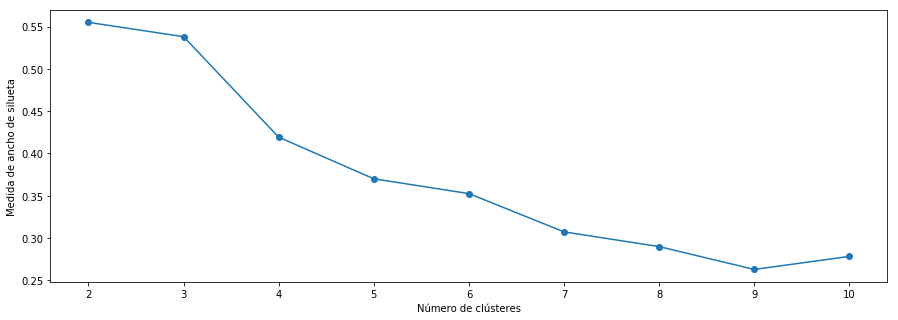

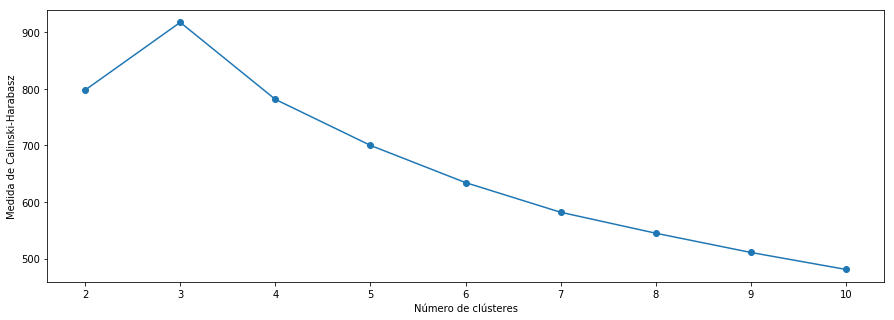

In [ ]:
# Comprobación de número de clusters adecuados
rsilueta = np.zeros(9)
rcalinski = np.zeros(9)

for k in np.arange(2,11):
    modelo = KMeans(n_clusters=k)
    modelo = modelo.fit(Dx)
    Dyp_sk = modelo.predict(Dx)
    cDx_sk = modelo.cluster_centers_
    rsilueta[k-2] = silhouette_score(Dx, Dyp_sk)
    rcalinski[k-2] = calinski_harabaz_score(Dx, Dyp_sk)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Medida de ancho de silueta")

fig, ax = plt.subplots(figsize=(15,5))
ax.plot( np.arange(2,11), rcalinski, linestyle='-', marker='o')
ax.set_xlabel("Número de clústeres")
ax.set_ylabel("Medida de Calinski-Harabasz")


### Resultado

Con esta técnica vemos que el número de $k$ apropiado parce ser $k=3$

In [ ]:
from sklearn.metrics import silhouette_samples
from mpl_toolkits.mplot3d import Axes3D

# función para dibujar la silueta
def plot_silhouettes(X, y):
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, y, metric='euclidean')
    y_ax_lower = 0
    y_ax_upper = 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
#         color = cm.jet(i / n_clusters)
        plt.barh(
            range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none'
        )
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color='red', linestyle='--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.show() 

# Función para mostrar los atributos más relevantes entre los recibidos
def mostrarAtributosRelevantes(Dx, Y):
    model = ExtraTreesClassifier(n_estimators=250, random_state=0)
    model.fit(X,Y)
    
    df = pd.DataFrame([[x, model.feature_importances_[x], columHeaders[x]] for x in range(len(columHeaders))],columns=['indice','importancia','atributo'])
    
    variables = df.sort_values('importancia',ascending=False).iloc[0:3]    
    
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(columHeaders,model.feature_importances_)
    ax.set_title('Relevancia de variables para K ='+ str(len(set(Y))))
    
    x_param = variables.iloc[0,0]
    y_param = variables.iloc[1,0]
    z_param = variables.iloc[2,0]
    
    x_label = columHeaders[x_param]
    y_label = columHeaders[y_param]
    z_label = columHeaders[z_param]
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(D[:,x_param],D[:,y_param], D[:,z_param], c = Y)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

### Observación de resultados gráficos

Intentamos sacar las variables más representativas del clasificador que parecen ser los cilindros y el desplazamiento.

A medida que aumentamos el número de $k$ el valor de los parámetros para el algoritmo se va igualando

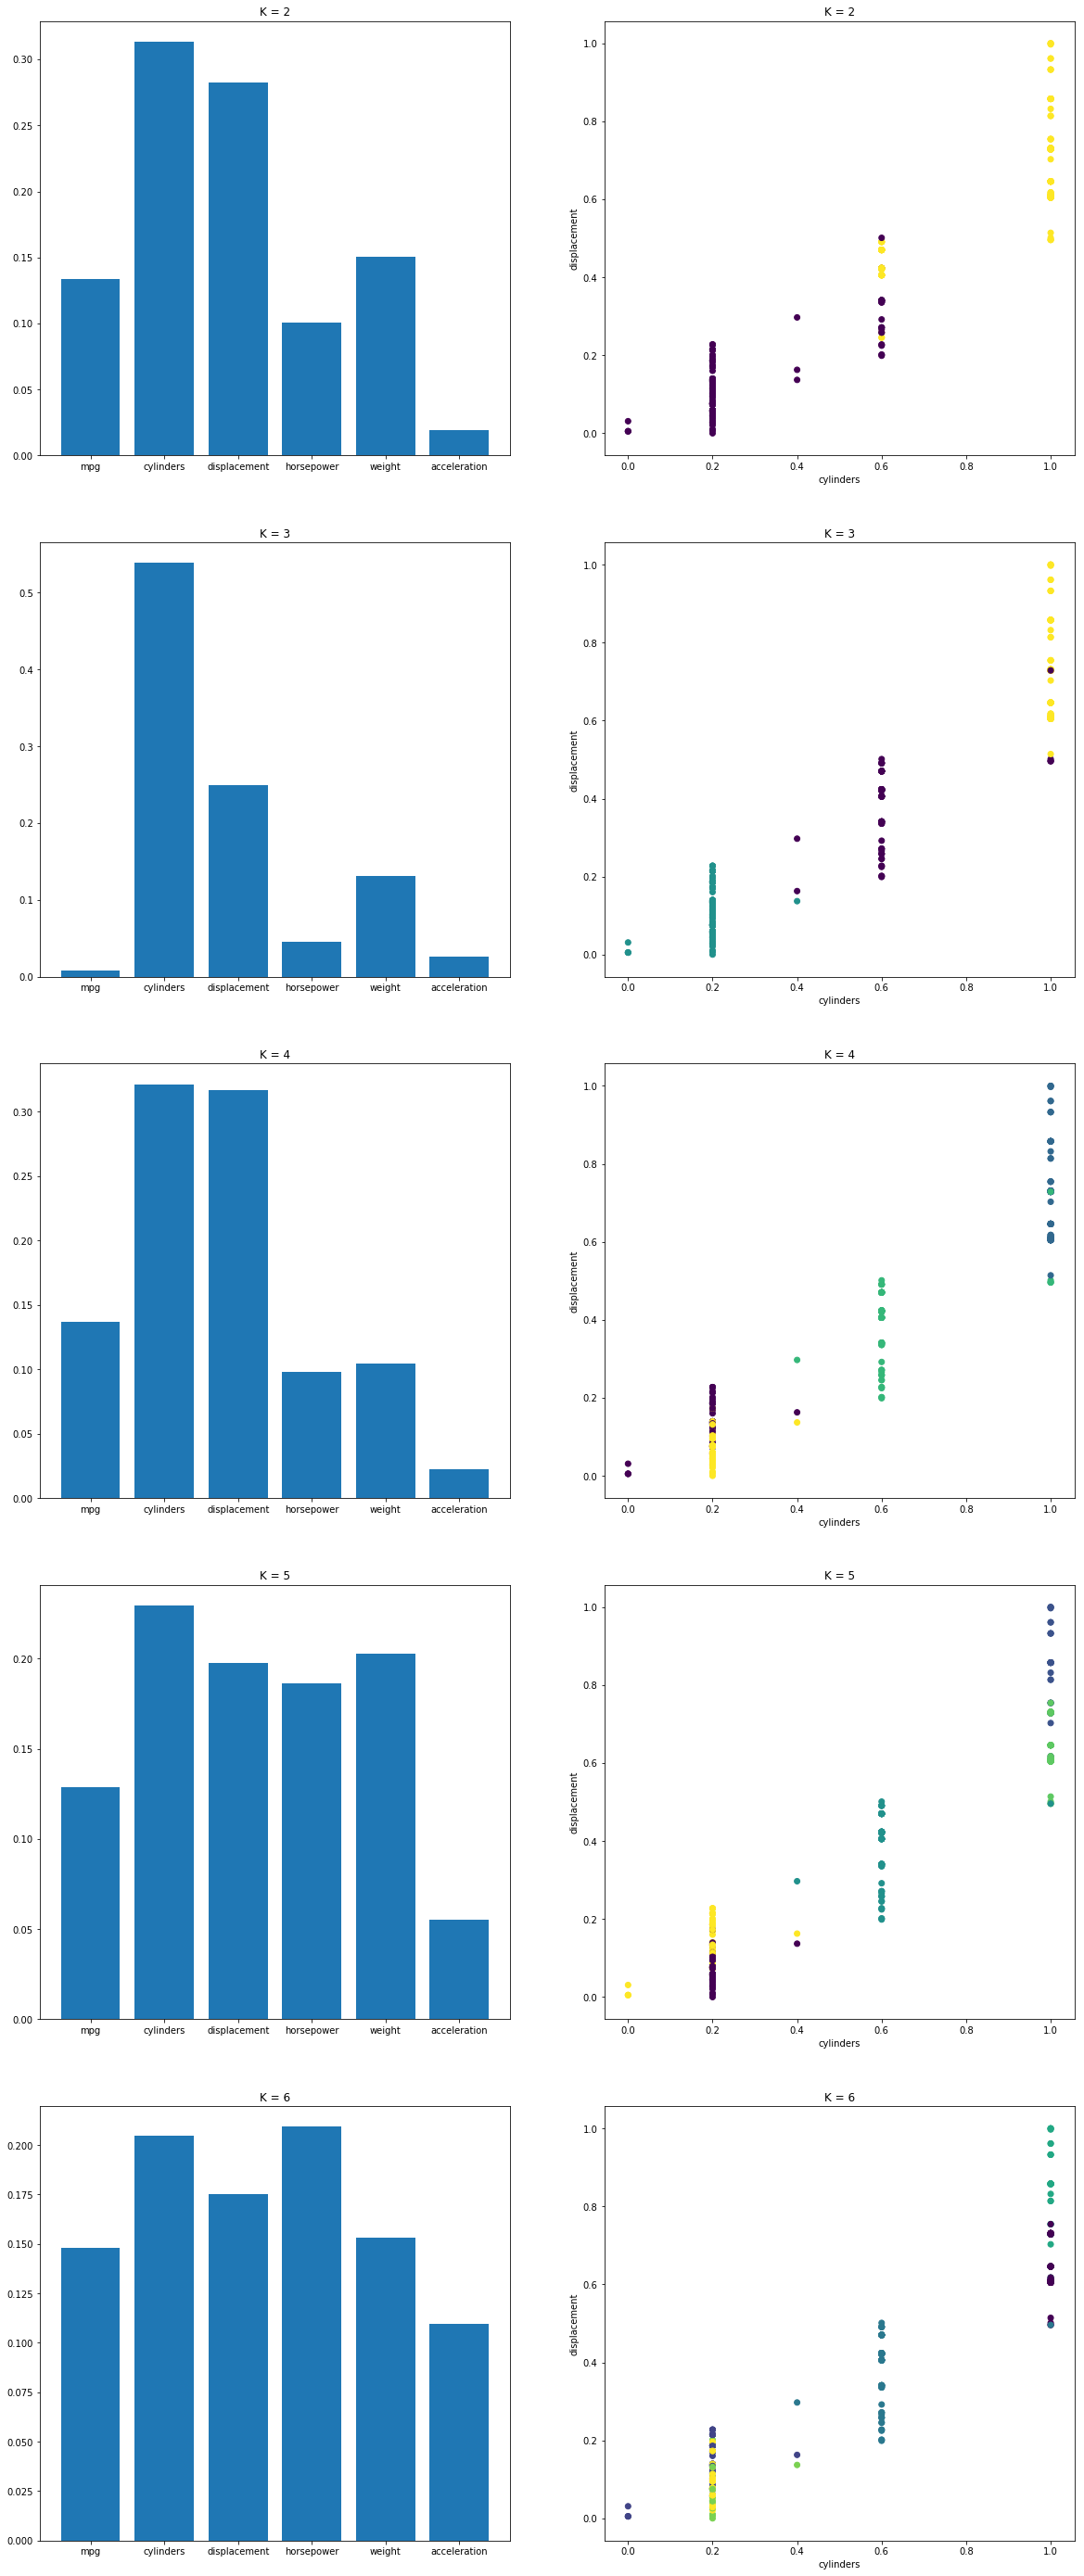

In [ ]:
from sklearn.metrics import mutual_info_score, silhouette_score, calinski_harabaz_score
from sklearn.ensemble import ExtraTreesClassifier

# Cambio la salida por consola de los números
np.set_printoptions(formatter={"float_kind": lambda x: "%g" % x})


rKM_cal = {}
rKM_sil = {}

fig, ax = plt.subplots(5,2,figsize=(20,50)) 

aux_graphf = 0
aux_graphc = 0

# Se inicializa KMeans con el número de clústeres a buscar
for nClusters in range(2,7):
    modelo = KMeans(n_clusters=nClusters)
    # Se aprende el 
    modelo = modelo.fit(Dx)
    # Predicting the clusters
    Dyp_sk = modelo.predict(Dx)
    result = modelo.labels_
    # Obtener los centros de los clústeres
    cDx_sk = modelo.cluster_centers_
    
    # Extracción de variables relevantes
    model = ExtraTreesClassifier()
    model.fit(Dx,Dyp_sk)

    ax[aux_graphf,0].bar(columHeaders,model.feature_importances_)
    ax[aux_graphf,0].set_title('K = ' + str(nClusters))
    
    ax[aux_graphf,1].scatter(Dx[:,1], Dx[:,2], c = Dyp_sk)
    ax[aux_graphf,1].set_title('K = ' + str(nClusters))
    ax[aux_graphf,1].set_xlabel("cylinders")
    ax[aux_graphf,1].set_ylabel("displacement")
    
    aux_graphf += 1
        
    rKM_cal[str(nClusters)] = calinski_harabaz_score(Dx, Dyp_sk)
    rKM_sil[str(nClusters)] = silhouette_score(Dx, Dyp_sk)



Resultados de la importancia de los atributos para $k=3$

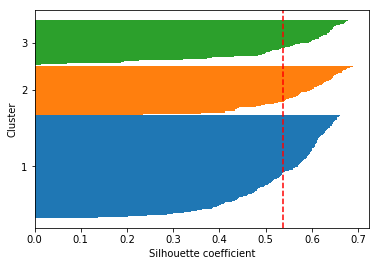

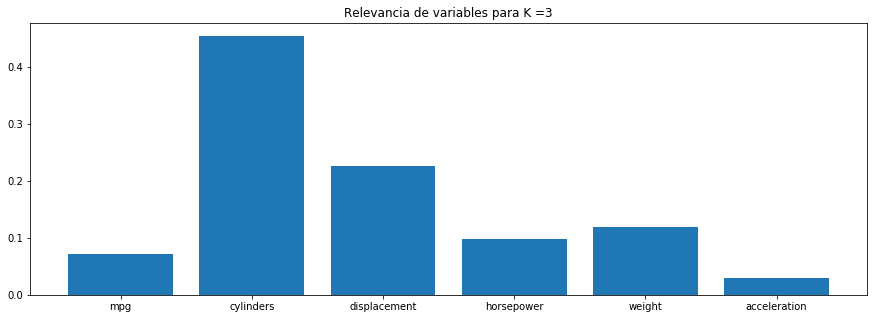

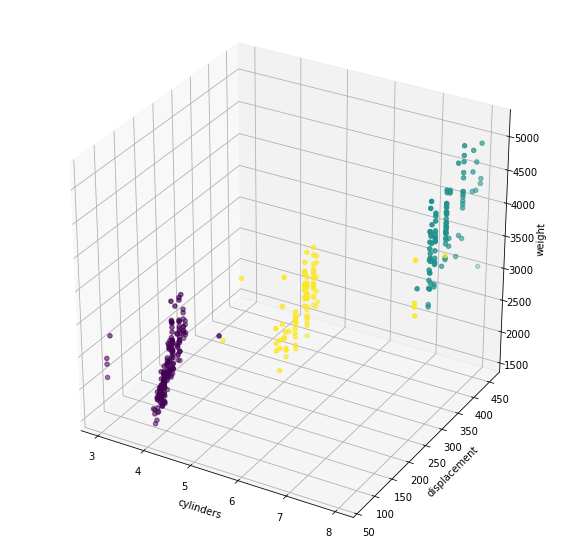

In [ ]:
nClusters = 3
modelo = KMeans(n_clusters=nClusters)
# Se aprende el 
modelo = modelo.fit(Dx)
X = Dx
Y = modelo.labels_

plt.subplot()
plot_silhouettes(X,Y)

mostrarAtributosRelevantes(X,Y)

### RESULTADOS

El número de cilindros parace ser una variable muy decisiva a la hora de asignar una muestra a un cluster, si observamos los gráficos de la distribución de los parámetros cilindros y desplazamiento de instancias respecto a los clusters, el gráfico con más sentido es el de la ejecución con $k=3$, que se corresponde con nuestras observaciones anteriores

# Clustering Jerárquico Aglomerativo

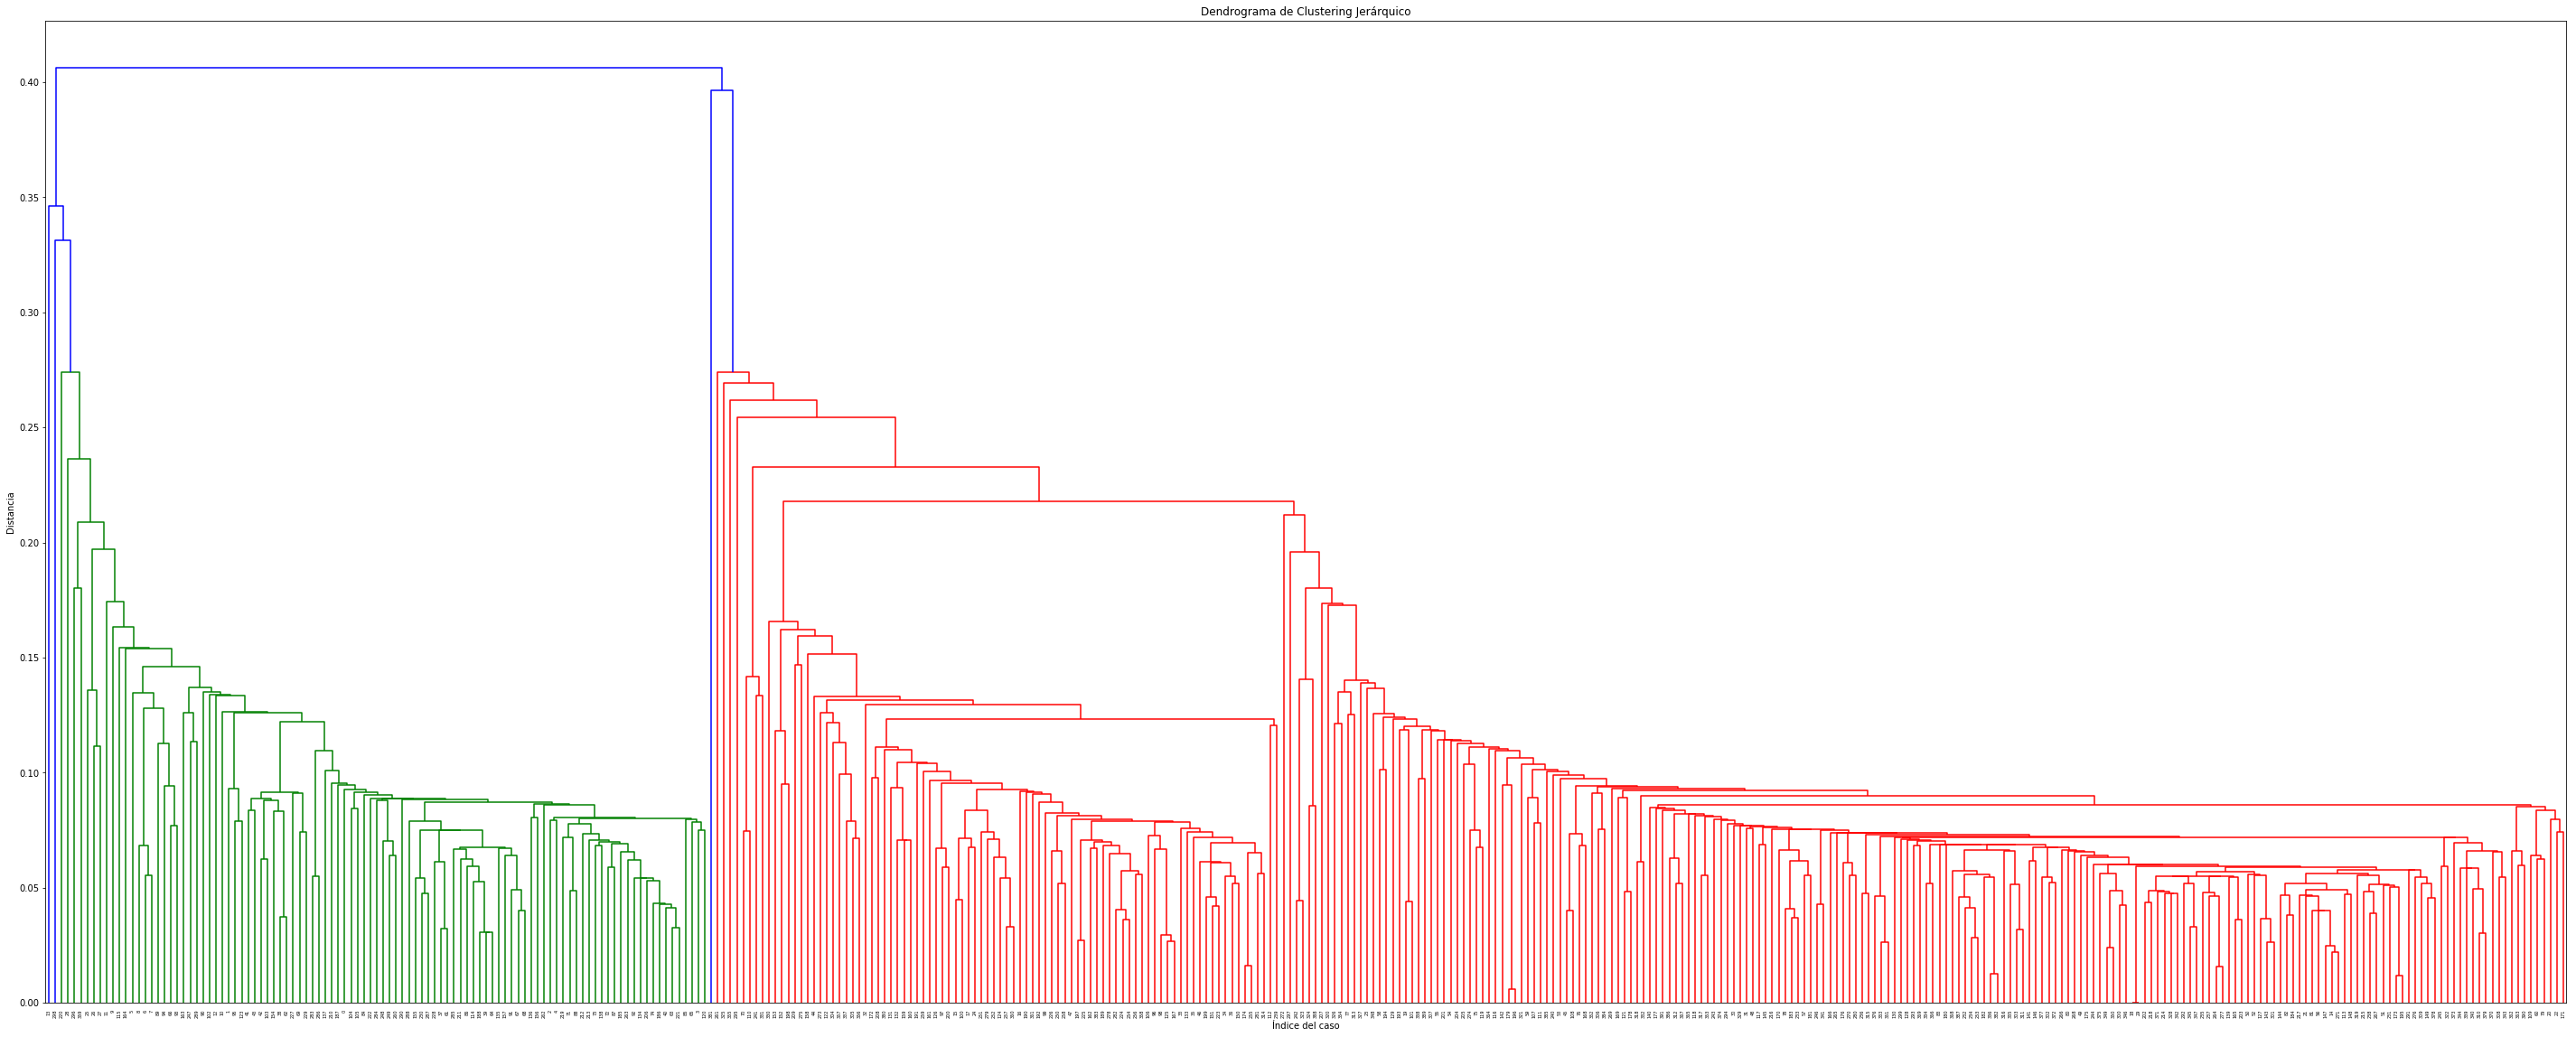

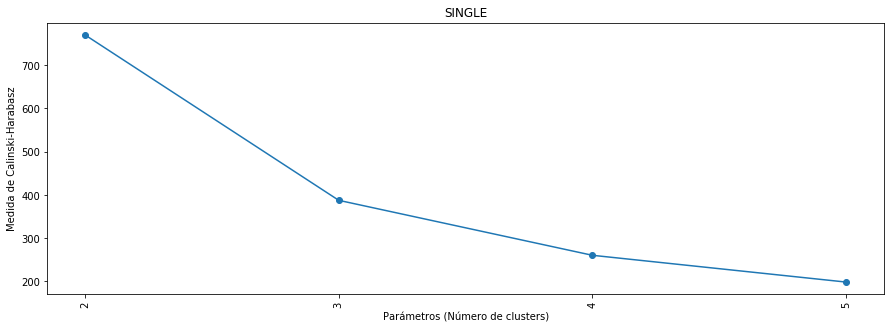

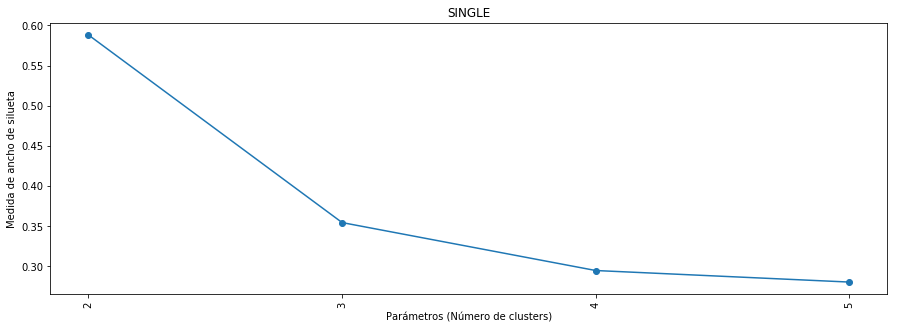

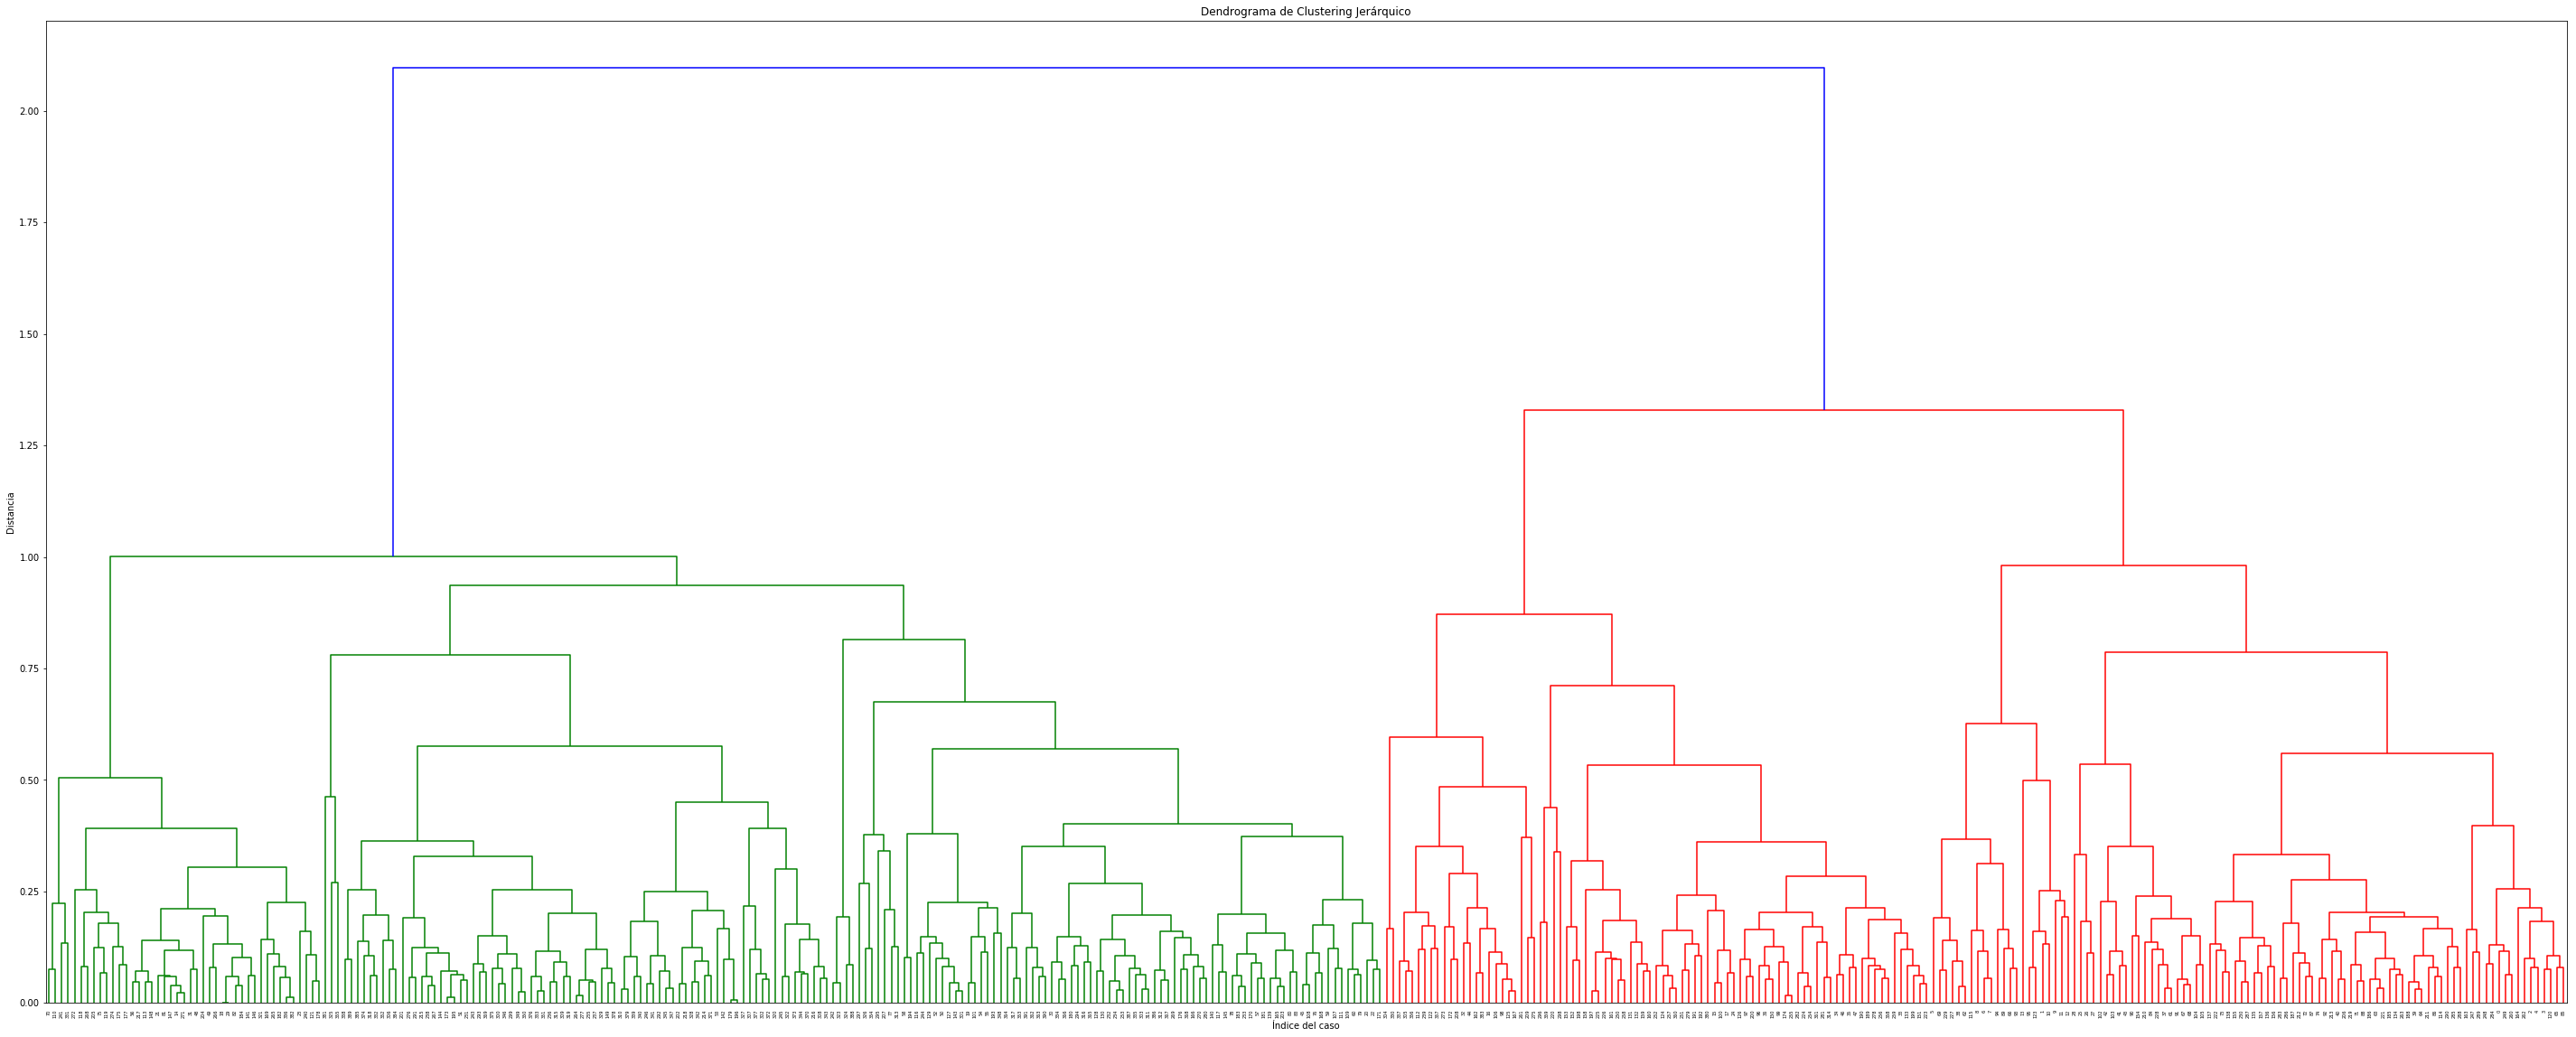

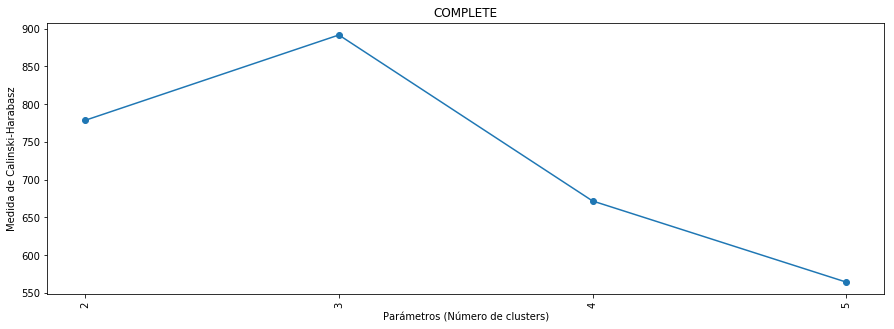

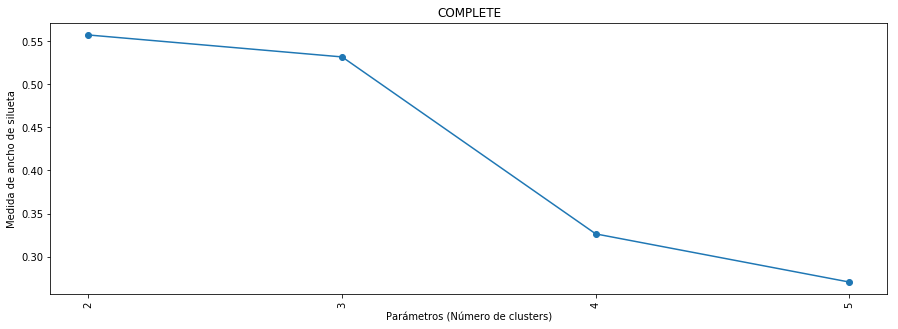

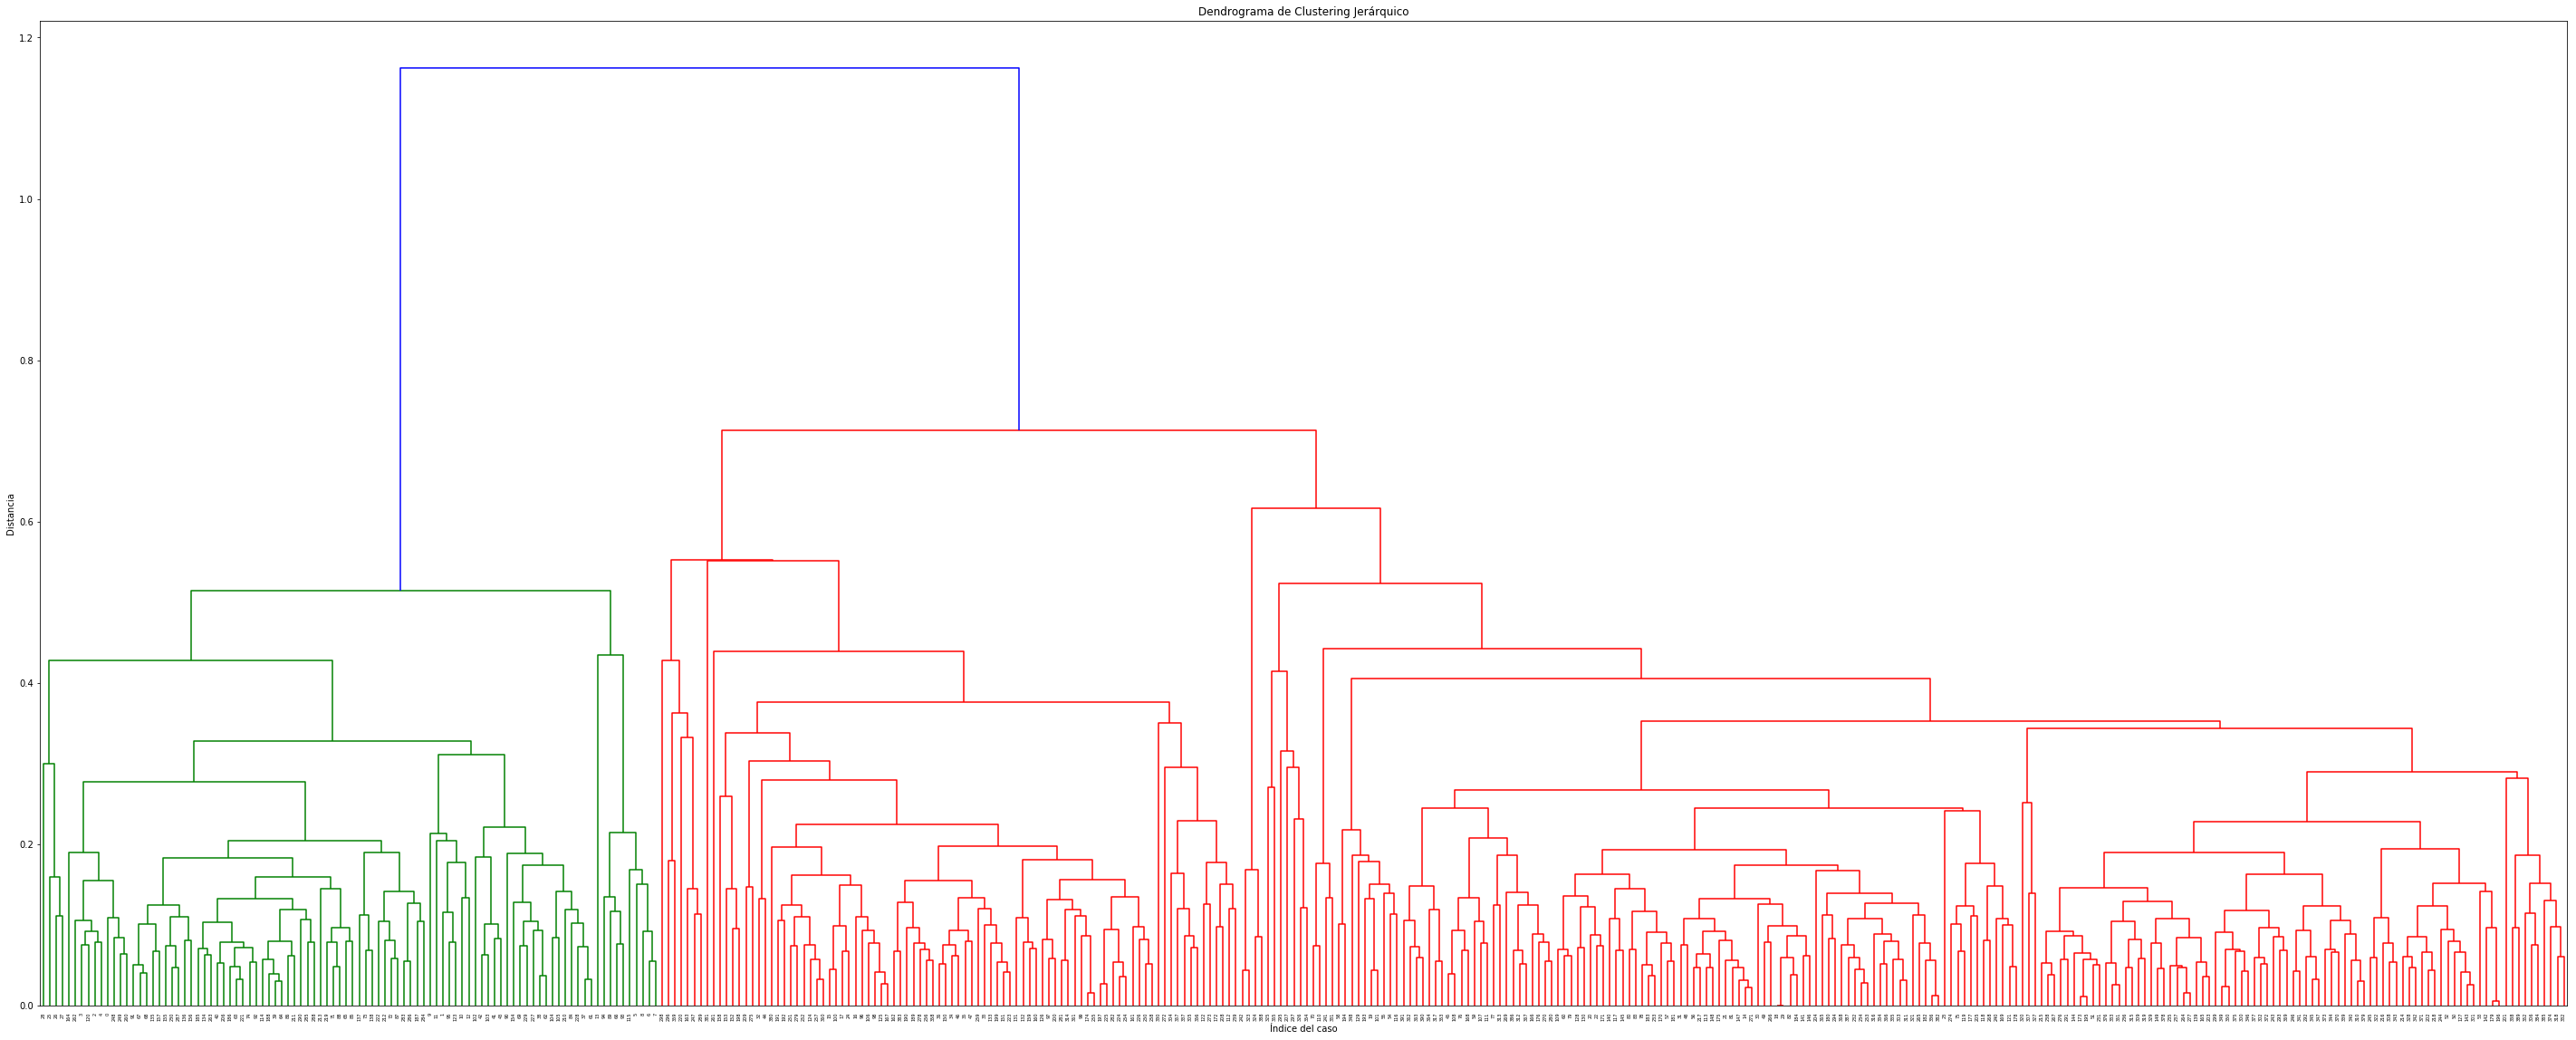

Text(0, 0.5, 'Medida de ancho de silueta')

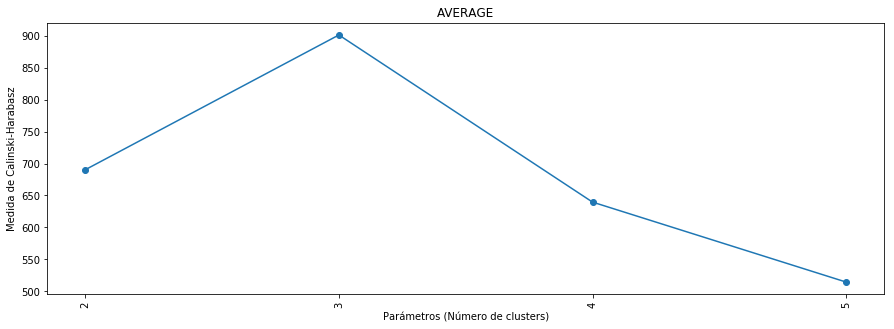

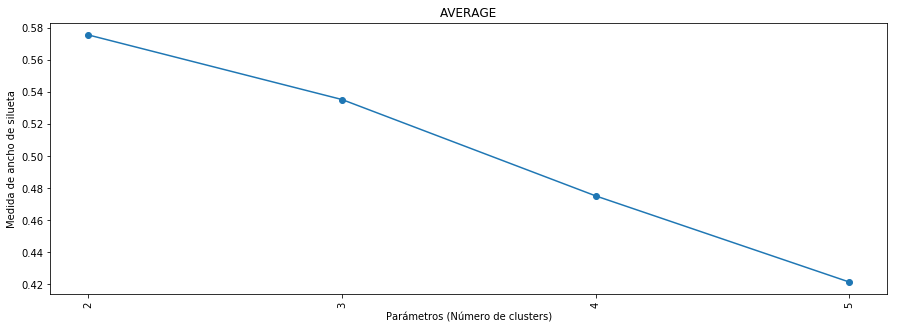

In [ ]:
from sklearn.cluster import AgglomerativeClustering

modelo_single = linkage(Dx, 'single')   # disimilitud mínima
modelo_completo = linkage(Dx, 'complete') # disimilitud máxima
modelo_average = linkage(Dx, 'average')  # disimilitud media

ag_KM_cal = {}
ag_KM_sil = {}
plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_single)
plt.show()
for nClusters in range(2,6):
    result = cut_tree(modelo_single, n_clusters=nClusters).flatten()
    Dyp_sk = result    
    ag_KM_cal[str(nClusters)] = calinski_harabaz_score(Dx, Dyp_sk)
    ag_KM_sil[str(nClusters)] = silhouette_score(Dx, Dyp_sk)
    
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(ag_KM_cal.keys(), ag_KM_cal.values(), linestyle='-', marker='o')
ax.set_title("SINGLE")
ax.set_xlabel("Parámetros (Número de clusters)")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(ag_KM_sil.keys(), ag_KM_sil.values(), linestyle='-', marker='o')
ax.set_title("SINGLE")
ax.set_xlabel("Parámetros (Número de clusters)")
ax.set_ylabel("Medida de ancho de silueta")


ag_KM_cal = {}
ag_KM_sil = {}
plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_completo)
plt.show()
for nClusters in range(2,6):
    result = cut_tree(modelo_completo, n_clusters=nClusters).flatten()
    Dyp_sk = result    
    ag_KM_cal[str(nClusters)] = calinski_harabaz_score(Dx, Dyp_sk)
    ag_KM_sil[str(nClusters)] = silhouette_score(Dx, Dyp_sk)
    
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(ag_KM_cal.keys(), ag_KM_cal.values(), linestyle='-', marker='o')
ax.set_title("COMPLETE")
ax.set_xlabel("Parámetros (Número de clusters)")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(ag_KM_sil.keys(), ag_KM_sil.values(), linestyle='-', marker='o')
ax.set_title("COMPLETE")
ax.set_xlabel("Parámetros (Número de clusters)")
ax.set_ylabel("Medida de ancho de silueta")


ag_KM_cal = {}
ag_KM_sil = {}    
plt.figure(figsize=(50, 20))
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índice del caso')
plt.ylabel('Distancia')
dendrogram(modelo_average)
plt.show()

for nClusters in range(2,6):
    result = cut_tree(modelo_average, n_clusters=nClusters).flatten()
    Dyp_sk = result    
    ag_KM_cal[str(nClusters)] = calinski_harabaz_score(Dx, Dyp_sk)
    ag_KM_sil[str(nClusters)] = silhouette_score(Dx, Dyp_sk)
    
fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(ag_KM_cal.keys(), ag_KM_cal.values(), linestyle='-', marker='o')
ax.set_title("AVERAGE")
ax.set_xlabel("Parámetros (Número de clusters)")
ax.set_ylabel("Medida de Calinski-Harabasz")

fig, ax = plt.subplots(figsize=(15,5))
plt.xticks(rotation=90)
ax.plot(ag_KM_sil.keys(), ag_KM_sil.values(), linestyle='-', marker='o')
ax.set_title("AVERAGE")
ax.set_xlabel("Parámetros (Número de clusters)")
ax.set_ylabel("Medida de ancho de silueta")

### RESULTADOS

Tal y como con el K-MEANS parace que un $k$ para los algoritmos aglomerativos se comporta mejor que uno alto

Destacar la mejora del aglomerativo de distancia completa y media con un $k=3$ que mejora significativamente el corte para $k=2$

A continuación mostramos gráficamente los resultados para el algoritmo aglomerativo uno mejores resultados (Average con 3 clusters)

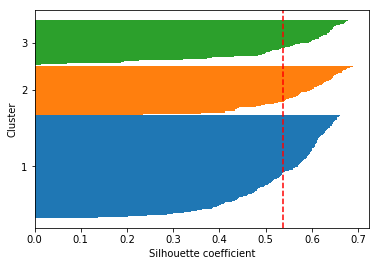

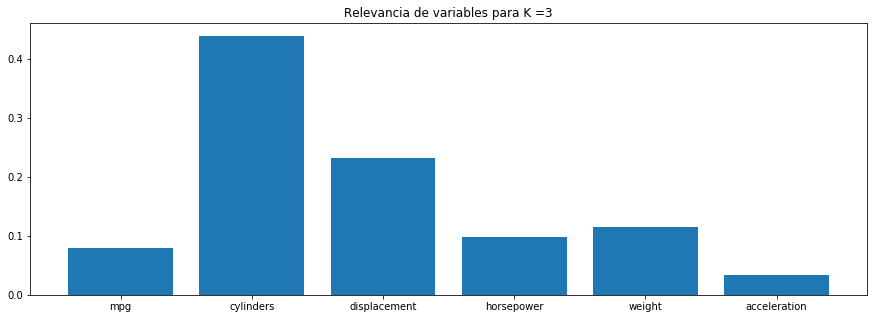

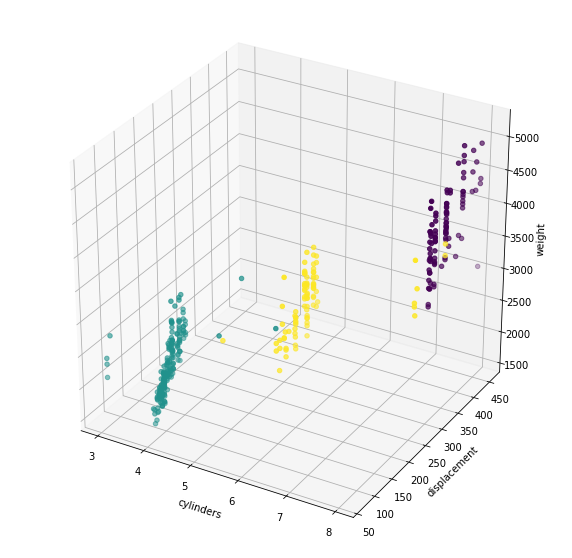

In [ ]:
result = cut_tree(modelo_average, n_clusters=3).flatten()
Dyp_sk = result

plot_silhouettes(Dx,Y)
mostrarAtributosRelevantes(Dx,result)

## AGRUPAMIENTO ESPECTRAL

Rank by calinski
    knn  nClusters  clusters  silhouette    calinski
30   15          3         3    0.533836  912.971355
37   22          3         3    0.533836  912.971355
27   12          3         3    0.533836  912.971355
28   13          3         3    0.533836  912.971355
29   14          3         3    0.533836  912.971355
32   17          3         3    0.533836  912.971355
33   18          3         3    0.533836  912.971355
26   11          3         3    0.533836  912.971355
35   20          3         3    0.533836  912.971355
36   21          3         3    0.533836  912.971355

Rank by silhouette
    knn  nClusters  clusters  silhouette    calinski
17   22          2         2    0.588117  766.188079
19   24          2         2    0.588117  766.188079
18   23          2         2    0.588117  766.188079
16   21          2         2    0.588117  766.188079
15   20          2         2    0.588117  766.188079
14   19          2         2    0.588117  766.188079
11   16  

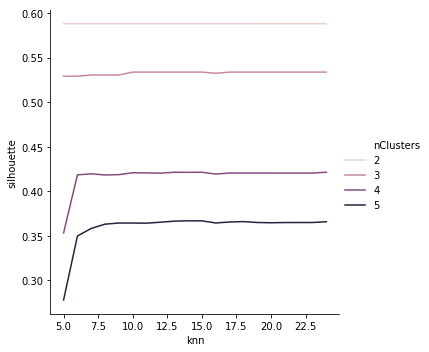

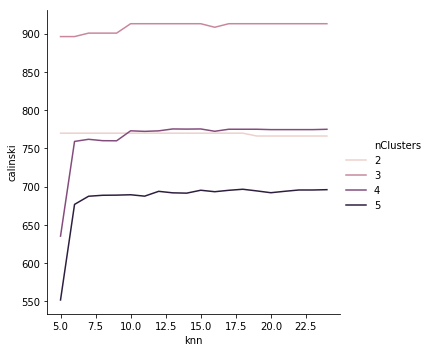

In [ ]:
import seaborn as sns

solucionsD = []
for nClusters in range(2,6):
    for knn in range(5,25,1):
        clustering = SpectralClustering(n_clusters = nClusters, affinity = 'nearest_neighbors', n_neighbors = knn, random_state = 0).fit(Dx)
        result = clustering.labels_
        if len(set(result)) != 0:
            solucionsD.append([ knn, nClusters,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])
        
df = pd.DataFrame(solucionsD,columns=['knn', 'nClusters', 'clusters', 'silhouette', 'calinski'])

sns.relplot(x="knn", y="silhouette",kind='line', hue='nClusters', data=df)
sns.relplot(x="knn", y="calinski",kind='line', hue='nClusters', data=df)

print("Rank by calinski")
print(df.sort_values("calinski",ascending=False).iloc[0:10])

print("\nRank by silhouette")
print(df.sort_values("silhouette",ascending=False).iloc[0:10])

### RESULTADOS

Para algoritmo espectral los resultados mejoran cuanto mayor sea el parámetro hasta llegar a $knn=10$, que se estanca.

Respecto al parámetro del número de clústers n_clusters, como en los algoritmos anteriores da mejores resultados con valores bajos $k=2$ y $k=3$ 

Mostramos resultados para la mejor configuración (3 clusters, 10 vecinos)

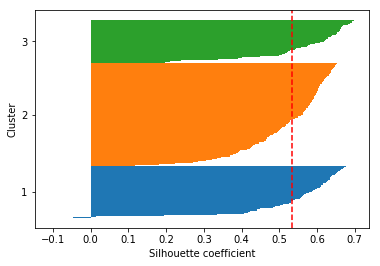

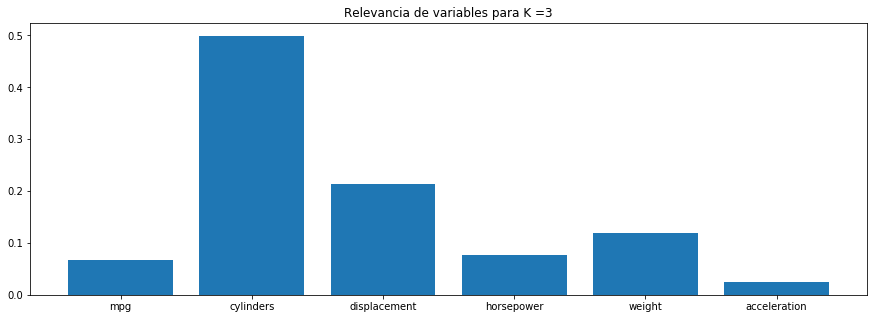

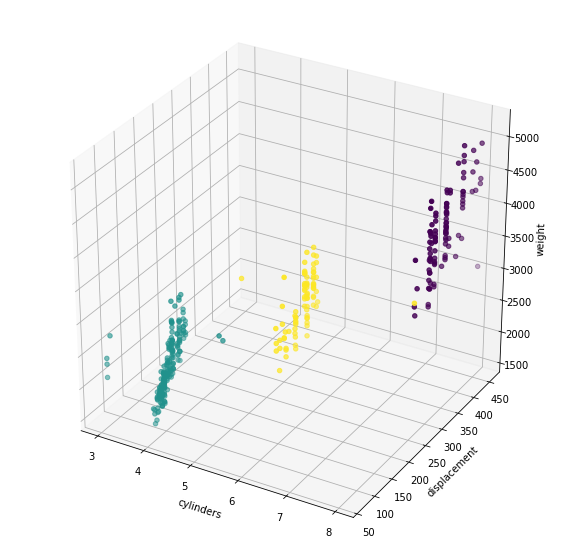

In [ ]:
clustering = SpectralClustering(n_clusters = 3, affinity = 'nearest_neighbors', n_neighbors = 10, random_state = 0).fit(Dx)
result = clustering.labels_

plot_silhouettes(Dx,result)
mostrarAtributosRelevantes(Dx,result)

# Agrupamiento basado en densidad - DBSCAN

Rank by calinski
    nSamples  nEps  clusters  silhouette    calinski
6         10  0.40         2    0.588091  769.901832
60       190  0.50         2    0.574082  747.993283
54       170  0.50         2    0.574082  747.993283
40       130  0.50         2    0.584514  747.602581
32       110  0.45         2    0.570052  743.372024
47       150  0.50         2    0.573871  742.731224
61       190  0.55         2    0.581838  733.390186
46       150  0.45         2    0.562148  732.763953
39       130  0.45         2    0.562148  732.763953
55       170  0.55         2    0.582057  730.551875

Rank by silhouette
    nSamples  nEps  clusters  silhouette    calinski
6         10  0.40         2    0.588091  769.901832
40       130  0.50         2    0.584514  747.602581
55       170  0.55         2    0.582057  730.551875
61       190  0.55         2    0.581838  733.390186
48       150  0.55         2    0.580198  718.033204
60       190  0.50         2    0.574082  747.993283
54       

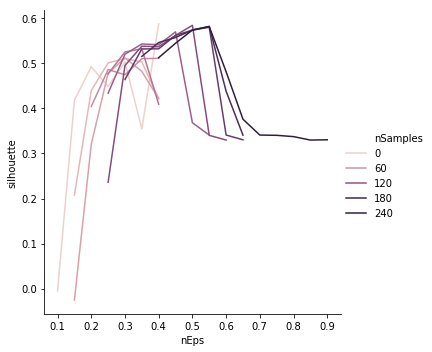

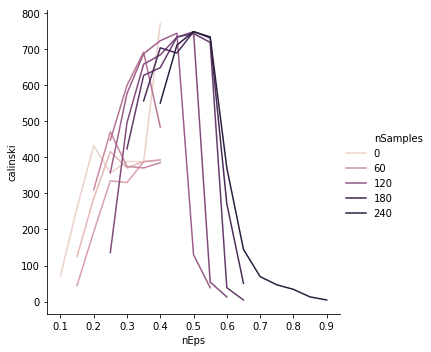

In [ ]:
solucionsD = []
for nSamples in np.arange(10,200,20):
    for nEps in np.arange(0.05,1,0.05):
        clustering = DBSCAN(eps=nEps, min_samples=nSamples).fit(Dx)
        result = clustering.labels_
        if len(set(result)) <= 1:
            continue
        solucionsD.append([ nSamples,nEps,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])

df = pd.DataFrame(solucionsD,columns=['nSamples', 'nEps', 'clusters', 'silhouette', 'calinski'])

sns.relplot(x="nEps", y="silhouette",kind='line', hue="nSamples", data=df)
sns.relplot(x="nEps", y="calinski",kind='line', hue="nSamples", data=df) 

print("Rank by calinski")
print(df.sort_values("calinski",ascending=False).iloc[0:10])

print("\nRank by silhouette")
print(df.sort_values("silhouette",ascending=False).iloc[0:10])

### RESULTADOS

Para el algoritmo DBSCAN los valores altos de sus parámetros dan buenos resultados para los valores de $minSamples>120$. Cuanto más ejemplos tiene el algoritmo más tarda en dar resultados con $eps's$ pequeños.

Tras las pruebas realizadas, se concluye que los mejores resultados son para $0.35<eps<0.55$

Las mejores ejecuciones de este algoritmo han generado 2 clusters

Mostramos resultados para 10 ejemplos y 0.4 de eps

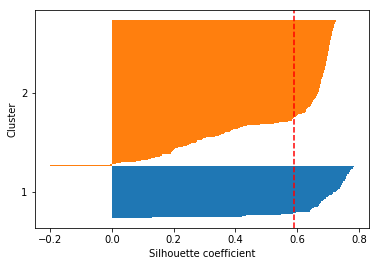

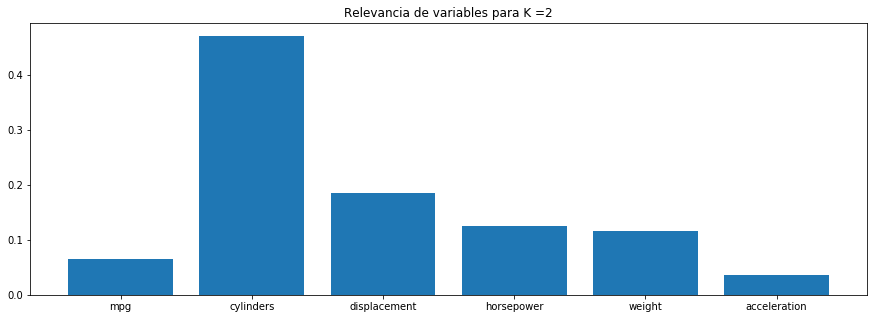

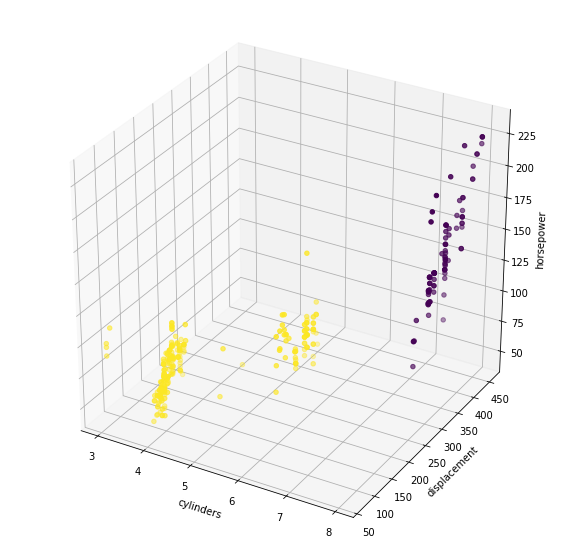

In [ ]:
clustering = DBSCAN(eps=0.4, min_samples=10).fit(Dx)
result = clustering.labels_

plot_silhouettes(Dx,result)
mostrarAtributosRelevantes(Dx,result)

# Agrupamiento basado en densidad - Mean Shift

Rank by calinski
    nBandwidth  clusters  silhouette    calinski
7         0.40         3    0.534759  916.104675
8         0.45         3    0.533813  914.605700
12        0.65         2    0.554944  797.787706
13        0.70         2    0.554944  797.787706
14        0.75         2    0.554944  797.787706
11        0.60         2    0.555442  797.740547
10        0.55         2    0.557316  792.114090
9         0.50         2    0.556982  776.282971
6         0.35         4    0.488892  621.428711
5         0.30         6    0.439936  423.681388

Rank by silhouette
    nBandwidth  clusters  silhouette    calinski
10        0.55         2    0.557316  792.114090
9         0.50         2    0.556982  776.282971
11        0.60         2    0.555442  797.740547
12        0.65         2    0.554944  797.787706
13        0.70         2    0.554944  797.787706
14        0.75         2    0.554944  797.787706
7         0.40         3    0.534759  916.104675
8         0.45         3    0.53

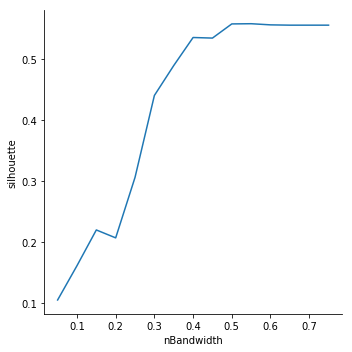

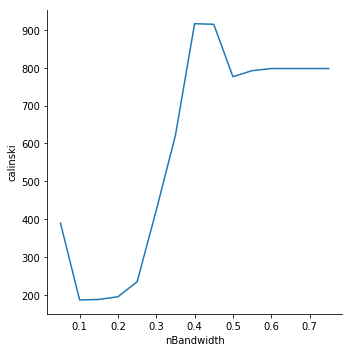

In [ ]:
solucionsD = []
for nBandwidth in np.arange(0.05,1,0.05):
    vBandwidth = nBandwidth
    clustering = MeanShift(bandwidth = vBandwidth).fit(Dx)
    
    result = clustering.labels_
    if np.sum(result) != 0:
        solucionsD.append([nBandwidth,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])    

df = pd.DataFrame(solucionsD,columns=['nBandwidth', 'clusters', 'silhouette', 'calinski'])

sns.relplot(x="nBandwidth", y="silhouette",kind='line', data=df)
sns.relplot(x="nBandwidth", y="calinski",kind='line', data=df) 

print("Rank by calinski")
print(df.sort_values("calinski",ascending=False).iloc[0:10])

print("\nRank by silhouette")
print(df.sort_values("silhouette",ascending=False).iloc[0:10])

### RESULTADOS

Para este algoritmo los resultados son bastante buenos. El valor del parámetro $bandwidth$ comprendido entre $0.4$ y $0.45$ genera 3 clusters con buenos resultados

Mostramos resultados para bandwidth de 0.4

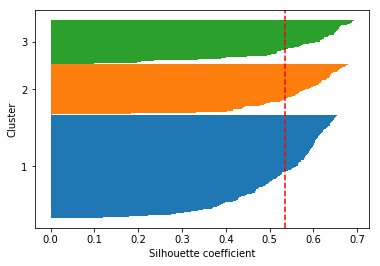

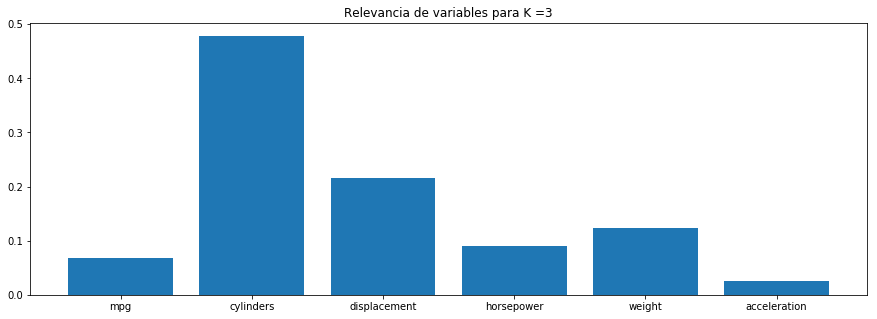

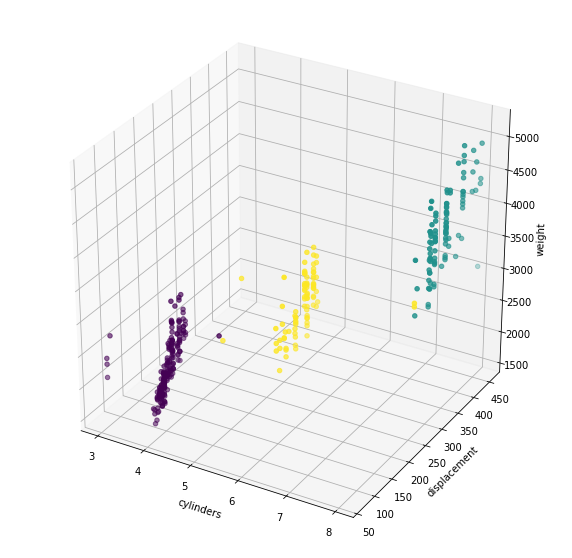

In [ ]:
clustering = MeanShift(bandwidth = 0.4).fit(Dx)
result = clustering.labels_

plot_silhouettes(Dx,result)
mostrarAtributosRelevantes(Dx,result)

# Agrupamiento basado en densidad - Affinity Propagation

In [ ]:
mSimilitud = euclidean_distances(Dx)
mSimilitud = -mSimilitud**2

rAffinity_cal = {}
rAffinity_sil = {}

solucionsD = []

for pref in np.arange(100,150,1):
    for factor in np.arange(0.6,0.91,0.1):
        preferencia = np.median(mSimilitud) * pref
        np.fill_diagonal(mSimilitud, preferencia)
        modelo = AffinityPropagation(preference=preferencia, damping=factor)
        Dyp_sk = modelo.fit_predict(Dx)
        # Condición para parar la iteración
        if np.max(Dyp_sk) <= 0 or np.max(Dyp_sk) >= (len(Dx)-1):
            print("Error: pref: %d, factor: %f " %(pref,factor))
            break
            
        rAffinity_cal[str(pref) + '_' + str(factor)] = calinski_harabaz_score(Dx, Dyp_sk)
        rAffinity_sil[str(pref) + '_' + str(factor)] = silhouette_score(Dx, Dyp_sk)        
        
        result = Dyp_sk
        solucionsD.append([ preferencia,factor,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])


df = pd.DataFrame(solucionsD,columns=['preferencia', 'factor' ,'clusters', 'silhouette', 'calinski'])  

sns.relplot(x="factor", y="silhouette",kind='line', hue="preferencia", data=df)
sns.relplot(x="factor", y="calinski",kind='line', hue="preferencia", data=df)

print("Rank by calinski")
print(df.sort_values("calinski",ascending=False).iloc[0:10])

print("\nRank by silhouette")
print(df.sort_values("silhouette",ascending=False).iloc[0:10])

### RESULTADOS

Para este algoritmo la enpezamos a tener resultados buenos a partir de $factor>0.65$ y con $preferencia>-60$.

A partir de éstos valores los resultados parecen estabilizarse. Todas las ejecuciones buenas han dado un número de clusters igual a 2

Realizamos un ejemplo de los valores con preferencia de (-50) y factor de 0.6

In [ ]:
modelo = AffinityPropagation(preference=-50, damping=0.6)
Dyp_sk = modelo.fit_predict(Dx)
result = Dyp_sk

plot_silhouettes(Dx,result)
mostrarAtributosRelevantes(Dx,result)

# Mixtura de Gaussianas y algoritmo EM

In [ ]:
solucionsD = []
for componentes in range(2,6):
    for iters in range(100,400,5):
        # Se inicializa el método con el número de clústeres (componentes) a buscar
        modelo = GaussianMixture(n_components = componentes, max_iter = iters)
        # Se aprende el modelo
        modelo = modelo.fit(Dx)
        # Se predicen las asignaciones a clústeres
        Dyp_sk = modelo.predict(Dx)
        result = Dyp_sk

        solucionsD.append([ componentes,iters,len(set(result)),silhouette_score(Dx,result),calinski_harabaz_score(Dx, result)])

df = pd.DataFrame(solucionsD,columns=['componentes', 'iters' ,'clusters', 'silhouette', 'calinski'])  

sns.relplot(x="iters", y="silhouette",kind='line', hue="componentes", data=df)
sns.relplot(x="iters", y="calinski",kind='line', hue="componentes", data=df)

print("Rank by calinski")
print(df.sort_values("calinski",ascending=False).iloc[0:10])

print("\nRank by silhouette")
print(df.sort_values("silhouette",ascending=False).iloc[0:10])

### RESULTADOS

Resultado interesante con este algoritmo ya que se producen dos fenomenos intereseantes al aumentar el número de iteraciones para los valores de componentes 2 y 3.

Para 2, 4 y 5 componentes las medidas reproducen un comportamiento oscilador cuando aumentamos el número de iteraciones (entre 150 y 300).

Para 3 componentes las medidas parecen estabilizarse.
Las mejores medidas de silueta se obtienen con 3 componentes y las de calinski con 3 componentes.

Realizaremos una visualización con ambos casos

In [ ]:
modelo =  GaussianMixture(n_components = 2, max_iter = 340)
Dyp_sk = modelo.fit_predict(Dx)
result = Dyp_sk

plot_silhouettes(Dx,result)
mostrarAtributosRelevantes(Dx,result)

In [ ]:
modelo =  GaussianMixture(n_components = 3, max_iter = 340)
Dyp_sk = modelo.fit_predict(Dx)
result = Dyp_sk

plot_silhouettes(Dx,result)
mostrarAtributosRelevantes(Dx,result)